In [ ]:
#!/usr/bin/env python3

import os
from random import randint, random

import h5py
import numpy as np
from PIL import Image, ImageDraw


def generate(dir_name, num_imgs):
    # `torchvision.datasets.ImageFolder` requires a subfolder
    os.makedirs(f'./msds1/{dir_name}/0', exist_ok=True)

    labels = np.empty((num_imgs, 4, 4, 6), dtype=np.int32)
    for count in range(num_imgs):
        item_color = (
            randint(0, 191) + 32,
            randint(0, 191) + 32,
            randint(0, 191) + 32,
        )

        img = Image.new('RGB', (32, 32), (0, 0, 0))
        for i in range(4):
            for j in range(4):
                item = Image.new('RGBA', (8, 8), (255, 255, 255, 0))
                draw = ImageDraw.Draw(item)

                now_color = (
                    item_color[0] + randint(-32, 32),
                    item_color[1] + randint(-32, 32),
                    item_color[2] + randint(-32, 32),
                    255,
                )
                draw.ellipse((1, 3, 7, 5), now_color)
                now_angle = random() * 180
                item = item.rotate(now_angle,
                                   resample=Image.Resampling.BICUBIC)

                now_pos = (
                    i * 8 + randint(-1, 1),
                    j * 8 + randint(-1, 1),
                )
                img.paste(item, now_pos, mask=item)

                label = now_pos + (now_angle, ) + now_color[:3]
                labels[count, i, j, :] = label

        img.save(f'./msds1/{dir_name}/0/{count:05d}.png', compress_level=1)

    with h5py.File(f'./msds1/{dir_name}_labels.hdf5', 'w') as f:
        f.create_dataset('labels',
                         data=labels,
                         compression='gzip',
                         shuffle=True)


def main():
    generate('train', 9 * 10**4)
    generate('test', 10**4)


if __name__ == '__main__':
    main()

In [ ]:
# msds1_dataset.py
import os
from pathlib import Path
from typing import Tuple, Optional, Callable

import h5py
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset

batch_size = 512

class MSDS1(Dataset):
    """
    Minimal PyTorch-style wrapper around the dataset generated by your script.

    • Each sample returns:
        img   –   torch.Tensor   (C, H, W)   –   by default in [0,1]
        label –   torch.Tensor   (4, 4, 6)   –   (x, y, angle, R, G, B)
    """

    def __init__(
        self,
        root: str | Path = "./msds1",
        split: str = "train",            # "train" | "test"
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        preload_labels: bool = True,     # load the entire HDF5 once; fine for 90k × 96 ints ≈ 35 MB
    ):
        super().__init__()

        split = split.lower()
        if split not in {"train", "test"}:
            raise ValueError(f"split must be 'train' or 'test', got {split!r}")

        self.img_dir = Path(root) / split / "0"
        self.img_paths = sorted(self.img_dir.glob("*.png"))          # 00000.png, 00001.png, …
        if not self.img_paths:
            raise FileNotFoundError(f"No images found in {self.img_dir}")

        # ------ labels ------------------------------------------------------
        h5_path = Path(root) / f"{split}_labels.hdf5"
        if not h5_path.exists():
            raise FileNotFoundError(h5_path)

        if preload_labels:
            with h5py.File(h5_path, "r") as f:
                self.labels = torch.from_numpy(f["labels"][...])     # (N, 4, 4, 6)
        else:
            # keep only the path; open lazily in __getitem__
            self.labels = None
            self._h5_path = h5_path

        # ------ optional transforms ----------------------------------------
        from torchvision.transforms import ToTensor
        self.transform = transform or ToTensor()
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_paths)

    # --------------------------------------------------------------------- #
    def _lazy_load_label(self, idx: int) -> torch.Tensor:
        """Open the HDF5 file every time (safer with num_workers>0)."""
        with h5py.File(self._h5_path, "r") as f:
            arr = f["labels"][idx]                   # (4, 4, 6) ndarray
        return torch.from_numpy(arr)

    # --------------------------------------------------------------------- #
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # --- image ---------------------------------------------------------
        img = Image.open(self.img_paths[idx]).convert("RGB")         # (32×32)
        if self.transform:
            img = self.transform(img)                                # torch.FloatTensor

        # --- label ---------------------------------------------------------
        if self.labels is not None:                                  # pre-loaded
            target = self.labels[idx]
        else:                                                        # lazy path
            target = self._lazy_load_label(idx)

        if self.target_transform:
            target = self.target_transform(target)

        return img, target


In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose

# -- transforms --------------------------------------------------------------
transforms = Compose([
    ToTensor()                         # PIL → [0,1] tenso
])

# -- datasets & loaders ------------------------------------------------------
train_ds = MSDS1(root="./msds1", split="train", transform=transforms)
test_ds  = MSDS1(root="./msds1", split="test",  transform=transforms)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

# ---- quick sanity check ----------------------------------------------------
images, labels = next(iter(train_loader))
print(images.shape)   # torch.Size([128, 3, 32, 32])
print(labels.shape)   # torch.Size([128, 4, 4, 6])


torch.Size([512, 3, 32, 32])
torch.Size([512, 4, 4, 6])


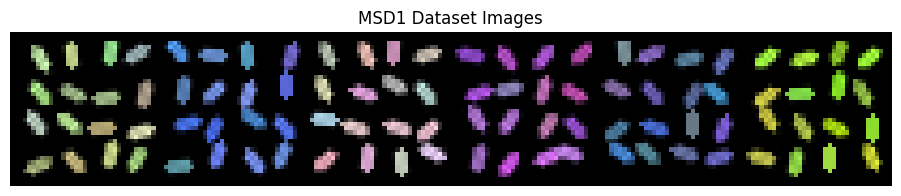

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def show_images(data_loader, num_images: int = 6, *, denorm=None):
    """
    Visualise `num_images` images from the first batch in `data_loader`.

    Args
    ----
    data_loader : torch.utils.data.DataLoader
        Your existing loader (train or val).
    num_images  : int
        How many images from the batch to plot (<= batch_size).
    denorm : callable or None
        Optionally reverse any normalisation applied in your transforms.
        Example:
            denorm = lambda x: x * 0.5 + 0.5        # if you used Normalize(mean=.5, std=.5)
    """
    # Grab one batch; no need to exhaust the iterator
    images, labels = next(iter(data_loader))       # labels ignored for plotting
    images = images[:num_images].cpu()

    if denorm is not None:
        images = denorm(images)

    # torchvision.utils.make_grid puts them into one canvas
    grid = torchvision.utils.make_grid(
        images, nrow=num_images, padding=2, normalize=False
    )
    grid = grid.permute(1, 2, 0).numpy()           # (C,H,W) → (H,W,C) for matplotlib

    plt.figure(figsize=(2 * num_images, 2))
    plt.imshow(grid)
    plt.title(f"MSD1 Dataset Images")
    plt.axis("off")
    plt.show()
show_images(train_loader)

In [ ]:
from torch.nn import init
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import torch.distributions as D
import os
from torch.nn.utils.parametrizations import weight_norm
from torch.profiler import profile, record_function, ProfilerActivity, schedule
from contextlib import nullcontext # Used to conditionally disable the profiler
from torch.utils.checkpoint import checkpoint
from math import sqrt, log
from typing import List, Tuple, Dict, Any, Optional, Union
import time
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision('high')

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from math import sqrt


class Swish(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(num_features))

    def forward(self, x):
        return x * torch.sigmoid(self.alpha * x)


class ResNet(nn.Module):
    def __init__(self, nres = 4, widths = [48, 512, 512, 48], final_scale = True):
        assert widths[0] == widths[-1]

        super().__init__()
        self.res_blocks = nn.ModuleList(
            [self.build_res_block(widths) for _ in range(nres)])

        if final_scale:
            self.scale = nn.Parameter(torch.zeros(widths[-1]))
        else:
            self.scale = None

    def build_linear(self, in_features, out_features):
        linear = nn.Linear(in_features, out_features)
        bound = sqrt(2.81 * 3 / in_features)
        nn.init.uniform_(linear.weight, -bound, bound)
        nn.init.zeros_(linear.bias)
        linear = weight_norm(linear)
        return linear

    def build_res_block(self, widths):
        layers = []
        for i in range(len(widths) - 1):
            layers.append(Swish(widths[i]))
            layers.append(self.build_linear(widths[i], widths[i + 1]))
        return nn.Sequential(*layers)

    def forward(self, x):
        for res_block in self.res_blocks:
            x = (x + res_block(x)) / sqrt(2)

        if self.scale is not None:
            x = x * self.scale

        return x


class ResidualNetwork(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        shape = x.shape  # (B*num_RG_blocks, C, K, K)
        x = x.view(shape[0], -1)  # (B*num_RG_blocks, C*K*K)
        x = super().forward(x)
        x = x.view(shape)
        return x

In [ ]:
def create_masks(kernel_size: int, num_channels:int) -> Tuple[torch.Tensor, torch.Tensor]:
    '''
    Create checkerboard masks for the RNVP block.
    Args:
        kernel_size: The size of the kernel
        num_channels: The number of channels in the input
    Returns:
        mask: The mask for the networks
        comask: The complementary mask such that mask + comask = 1
    '''
    checkerboard = torch.from_numpy(np.indices((kernel_size, kernel_size)).sum(axis=0) % 2).float()
    mask = checkerboard.unsqueeze(0).repeat(num_channels, 1, 1)
    comask = 1 - mask
    return mask, comask

class RNVPBlock(nn.Module):
    mask: torch.Tensor
    comask: torch.Tensor

    def __init__(
        self,
        kernel_size: int,
        num_channels: int,
        s_nets: List[nn.Module],
        t_nets: List[nn.Module],
        *,
        apply_tanh: bool = True,
        use_ckpt: bool  = True,
    ):
        super().__init__()
        assert len(s_nets) == len(t_nets), "Need the same number of s and t networks"
        self.s_nets  = nn.ModuleList(s_nets)
        self.t_nets  = nn.ModuleList(t_nets)
        self.apply_tanh = apply_tanh
        self.use_ckpt   = use_ckpt

        mask, comask = create_masks(kernel_size, num_channels)
        self.register_buffer("mask",   mask)        # (C,H,W)
        self.register_buffer("comask", comask)


    def _checkpoint(self, fn, x):
        if self.training and self.use_ckpt and x.requires_grad:
            return checkpoint(fn, x, use_reentrant=False)   # saves memory
        else:
            return fn(x)

    def _one_forward_flow(
        self, x: torch.Tensor, s_net: nn.Module, t_net: nn.Module
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        x1, x2 = x * self.mask, x * self.comask

        # step 1: mask -> comask
        s1 = self.comask * self._checkpoint(s_net, x1)
        t1 = self.comask * self._checkpoint(t_net, x1)
        if self.apply_tanh:  s1 = torch.tanh(s1)
        x2_ = self.comask * (torch.exp(s1) * x2 + t1)
        ldj  = s1.sum(dim=(1, 2, 3))

        # step 2: comask -> mask
        s2 = self.mask * self._checkpoint(s_net, x2_)
        t2 = self.mask * self._checkpoint(t_net, x2_)
        if self.apply_tanh:  s2 = torch.tanh(s2)
        x1_ = self.mask * (torch.exp(s2) * x1 + t2)
        ldj += s2.sum(dim=(1, 2, 3))

        return x1_ + x2_, ldj

    def _one_inverse_flow(
        self, x: torch.Tensor, s_net: nn.Module, t_net: nn.Module
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        x1, x2 = x * self.mask, x * self.comask

        # step 2⁻¹
        s2 = self.mask * self._checkpoint(s_net, x2)
        t2 = self.mask * self._checkpoint(t_net, x2)
        if self.apply_tanh:  s2 = torch.tanh(s2)
        x1_ = self.mask * torch.exp(-s2) * (x1 - t2)
        ldj  = -s2.sum(dim=(1, 2, 3))

        # step 1⁻¹
        s1 = self.comask * self._checkpoint(s_net, x1_)
        t1 = self.comask * self._checkpoint(t_net, x1_)
        if self.apply_tanh:  s1 = torch.tanh(s1)
        x2_ = self.comask * torch.exp(-s1) * (x2 - t1)
        ldj -= s1.sum(dim=(1, 2, 3))

        return x1_ + x2_, ldj

    def forward(self, x):
        ldj = torch.zeros(x.size(0), device=x.device)
        for s_net, t_net in zip(self.s_nets, self.t_nets):
            x, inc = self._one_forward_flow(x, s_net, t_net)
            ldj += inc
        return x, ldj

    def inverse(self, z):
        ldj = torch.zeros(z.size(0), device=z.device)
        for s_net, t_net in zip(reversed(self.s_nets), reversed(self.t_nets)):
            z, inc = self._one_inverse_flow(z, s_net, t_net)
            ldj += inc
        return z, ldj


In [ ]:
def shift_kernel_blocks(x: torch.Tensor, m: int, h:int, inverse : bool = False) -> torch.Tensor:
    shift = (m // 2) * (2 ** h)
    if not inverse:
        return torch.roll(x, shifts=(-shift, -shift), dims=(-2, -1))
    else:
        return torch.roll(x, shifts=(shift, shift), dims=(-2, -1))

class MERABlock(nn.Module):
    def __init__(self, m, h, network, shift=False):
        super().__init__()
        self.m = m
        self.h = h
        self.network = network # Should have forward and inverse methods
        self.dilation = 2 ** h
        self.stride = m * self.dilation
        self.unfold = nn.Unfold(kernel_size=m, dilation=self.dilation, stride=self.stride)
        self.fold = None
        self.shift = shift
        self.cached_mask = None

    def _apply_flow(self, x, flow_method):
        B, C, H, W = x.shape

        x_orig = x
        x_to_process = x
        if self.shift:
            x_to_process = shift_kernel_blocks(x, self.m, self.h)

        patches = self.unfold(x_to_process)

        num_patches = patches.shape[-1]
        patches_reshaped = patches.view(B, C, self.m, self.m, num_patches).permute(0, 4, 1, 2, 3).reshape(B * num_patches, C, self.m, self.m)

        # Apply the specified flow method (forward or inverse)
        transformed_patches, ldj = flow_method(patches_reshaped)

        transformed_patches_reshaped = transformed_patches.view(B, num_patches, C, self.m, self.m).permute(0, 2, 3, 4, 1).reshape(B, C * self.m * self.m, num_patches)

        if self.fold is None:
            self.fold = nn.Fold(output_size=(H, W), kernel_size=self.m, dilation=self.dilation, stride=self.stride)
            with torch.no_grad():
                single_item_patches = patches.narrow(0, 0, 1)
                self.cached_mask = self.fold(torch.ones_like(single_item_patches))

        folded = self.fold(transformed_patches_reshaped)

        mask = self.cached_mask.expand(B, C, H, W)

        if self.shift:
            folded = shift_kernel_blocks(folded, self.m, self.h, inverse=True)
            mask = shift_kernel_blocks(mask, self.m, self.h, inverse=True)

        x_updated = torch.where(mask.bool(), folded, x_orig)

        return x_updated, ldj.view(B, -1).sum(dim=1)

    def forward(self, x):
        return self._apply_flow(x, self.network.forward)

    def inverse(self, x):
        return self._apply_flow(x, self.network.inverse)

class RG_Flow(nn.Module):
    """A full MERA model built from a sequence of MERABlock layers."""
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        ldj = torch.zeros(x.shape[0], device=x.device)
        for layer in self.layers:
            x, ldj_ = layer.forward(x)
            ldj += ldj_
        return x, ldj

    def inverse(self, x):
        ldj = torch.zeros(x.shape[0], device=x.device)
        for layer in reversed(self.layers):
            x, ldj_ = layer.inverse(x)
            ldj += ldj_
        return x, ldj

In [ ]:
class PriorDistribution(nn.Module):
    def __init__(self, dist_type='laplace'):
        super().__init__()
        if dist_type == 'laplace':
            self.base_dist = D.Laplace
        elif dist_type == 'gaussian':
            self.base_dist = D.Normal
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")

    def __repr__(self):
        return f"PriorDistribution(dist_type={self.base_dist.__name__})"

    def log_prob(self, z, temperature=1.0):
        dist = self.base_dist(loc=torch.zeros_like(z), scale=torch.ones_like(z) * temperature)
        return dist.log_prob(z).sum(dim=[1, 2, 3]) # Sum over all dimensions except batch

    def sample(self, shape, temperature=1.0):
        dist = self.base_dist(loc=torch.zeros(shape), scale=torch.ones(shape) * temperature)
        return dist.sample()

In [ ]:
n_layers = [4, 4, 4, 4, 4, 4, 4, 4]

layers = []
for n in n_layers:
    s_nets = [ResidualNetwork() for _ in range(n)]
    t_nets = [ResidualNetwork() for _ in range(n)]
    layers.append(RNVPBlock(kernel_size=4, num_channels=3, s_nets=s_nets, t_nets=t_nets, apply_tanh=True, use_ckpt=True))

MERA_layers = []
for i, layer in enumerate(layers):
    MERA_layers.append(
        MERABlock(m=4, h = i // 2, network=layer, shift=(i % 2 == 1))
    )
flow = RG_Flow(MERA_layers)
flow.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


RG_Flow(
  (layers): ModuleList(
    (0-1): 2 x MERABlock(
      (network): RNVPBlock(
        (s_nets): ModuleList(
          (0-3): 4 x ResidualNetwork(
            (res_blocks): ModuleList(
              (0-3): 4 x Sequential(
                (0): Swish()
                (1): Linear(in_features=48, out_features=512, bias=True)
                (2): Swish()
                (3): Linear(in_features=512, out_features=512, bias=True)
                (4): Swish()
                (5): Linear(in_features=512, out_features=48, bias=True)
              )
            )
          )
        )
        (t_nets): ModuleList(
          (0-3): 4 x ResidualNetwork(
            (res_blocks): ModuleList(
              (0-3): 4 x Sequential(
                (0): Swish()
                (1): Linear(in_features=48, out_features=512, bias=True)
                (2): Swish()
                (3): Linear(in_features=512, out_features=512, bias=True)
                (4): Swish()
                (5): Linear(in_fea

In [ ]:
def logit_transform(x, dequant=True, constraint=0.9, inverse=False):
    if inverse:
        logit_x = x
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) -
               F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)

        # Inverse logit transform
        x = 1 / (1 + torch.exp(-logit_x))    # [0.05, 0.95]

        # Unrestrict data
        x *= 2    # [0.1, 1.9]
        x -= 1    # [-0.9, 0.9]
        x /= constraint    # [-1, 1]
        x += 1    # [0, 2]
        x /= 2    # [0, 1]

        return x, ldj

    else:
        if dequant:
            # Dequantization
            noise = torch.rand_like(x)
            x = (x * 255 + noise) / 256

        # Restrict data
        x *= 2    # [0, 2]
        x -= 1    # [-1, 1]
        x *= constraint    # [-0.9, 0.9]
        x += 1    # [0.1, 1.9]
        x /= 2    # [0.05, 0.95]

        # Logit transform
        logit_x = torch.log(x) - torch.log(1 - x)

        # Log-determinant of Jacobian from the transform
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) -
               F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)

        return logit_x, ldj

In [ ]:
def generate_and_show_images(
    model: RG_Flow,
    prior: PriorDistribution,
    epoch: int,
    num_images: int,
    image_dims: tuple,
    device: str,
    save_dir: str = "generated_images"
):
    """
    Generates images from the model, displays them, and saves them to a file.

    Args:
        model: The RG_Flow model instance.
        prior: The prior distribution.
        epoch: The current epoch number (for titling and saving).
        num_images: The number of images to generate.
        image_dims: A tuple of (channels, height, width).
        device: The device to run generation on.
        save_dir: Directory to save the generated images.
    """
    # 1. Set the model to evaluation mode
    model.eval()

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        # 2. Sample z from the prior distribution
        n_channels, height, width = image_dims
        z_shape = (num_images, n_channels, height, width)
        z = prior.sample(z_shape).to(device)

        # 3. Pass z through the inverse of the model to get generated image logits
        generated_logits, _ = model.inverse(z)

        # 4. Apply the inverse logit transform to get pixel values in [0, 1]
        generated_images, _ = logit_transform(generated_logits, dequant=False, inverse=True)

        # Move images to CPU for visualization/saving
        generated_images = generated_images.cpu()

        # Clamp values to be safe for visualization
        generated_images = torch.clamp(generated_images, 0, 1)

    # 5. Create a grid and display/save the images
    # We assume a square grid, so num_images should ideally be a perfect square (e.g., 16, 36)
    grid = torchvision.utils.make_grid(generated_images, nrow=int(sqrt(num_images)))
    img_grid = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(img_grid)
    plt.title(f"Generated Images at Epoch {epoch + 1}")
    plt.axis('off')

    # Save the figure
    plt.savefig(os.path.join(save_dir, f"epoch_{epoch+1:03d}.png"))
    plt.show() # Display the plot in the notebook/console

    # 6. Set the model back to training mode for the next epoch
    model.train()

In [ ]:
import logging
import time
from datetime import datetime

def setup_logger(name='rg_flow_training'):
    """
    Sets up a logger that writes to a file and the console.
    """
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)


    logger.propagate = False


    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s',
                                  datefmt='%Y-%m-%d %H:%M:%S')


    log_filename = f"training_run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log"
    file_handler = logging.FileHandler(log_filename)
    file_handler.setFormatter(formatter)


    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)

    if not logger.handlers:
        logger.addHandler(file_handler)
        logger.addHandler(stream_handler)

    return logger

In [ ]:
def train_rg_flow(
    model: RG_Flow,
    prior: PriorDistribution,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    device: str,
    image_dims: tuple,
    logger: logging.Logger,
    num_images_to_generate: int = 16
):
    """
    The main training loop for the RG-Flow model.
    ... (args documentation) ...
    Args:
        logger: A configured logger object.
    """
    model.train()
    model.to(device)
    prior.to(device)

    n_channels, height, width = image_dims
    bpd_factor = np.log(2) * n_channels * height * width
    logger.info(f"Training for {num_epochs} epochs...")
    logger.info(f"Batch size: {BATCH_SIZE}")
    logger.info(f"Learning rate: {LEARNING_RATE}")
    logger.info(f"Image dimensions: {image_dims}")
    logger.info(f"Number of images to generate: {num_images_to_generate}")
    logger.info(prior)

    logger.info("--- Starting Training ---")
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_loss = 0.0

        for batch_idx, (x, _) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            x, ldj_logit = logit_transform(x)
            z_final, ldj_combined = model.forward(x)
            logp_prior = prior.log_prob(z_final)
            total_log_likelihood = logp_prior + ldj_combined + ldj_logit
            loss = -torch.mean(total_log_likelihood)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            total_loss += loss.item()

            if batch_idx % 50 == 0:
                bpd = (loss.item() + np.log(256.) * (n_channels * height * width)) / bpd_factor
                logger.info(f"Epoch: {epoch+1}/{num_epochs} | Batch: {batch_idx}/{len(train_loader)} | Loss (NLL): {loss.item():.4f} | BPD: {bpd:.4f}")

        avg_loss = total_loss / len(train_loader)
        epoch_time = time.time() - epoch_start_time
        logger.info(f"--- Epoch {epoch+1} Summary ---")
        logger.info(f"Average Loss: {avg_loss:.4f} | Time: {epoch_time:.2f}s")

        logger.info("Generating sample images...")
        generate_and_show_images(
            model=model,
            prior=prior,
            epoch=epoch,
            num_images=num_images_to_generate,
            image_dims=image_dims,
            device=device
        )

        logger.info("-" * 30)

2025-07-07 10:25:52 - INFO - Training for 60 epochs...
2025-07-07 10:25:52 - INFO - Batch size: 512
2025-07-07 10:25:52 - INFO - Learning rate: 0.001
2025-07-07 10:25:52 - INFO - Image dimensions: (3, 32, 32)
2025-07-07 10:25:52 - INFO - Number of images to generate: 16
2025-07-07 10:25:52 - INFO - PriorDistribution(dist_type=Laplace)
2025-07-07 10:25:52 - INFO - --- Starting Training ---
2025-07-07 10:25:56 - INFO - Epoch: 1/60 | Batch: 0/176 | Loss (NLL): 1481.2131 | BPD: 8.6956
2025-07-07 10:27:40 - INFO - Epoch: 1/60 | Batch: 50/176 | Loss (NLL): -5404.4292 | BPD: 5.4619
2025-07-07 10:29:24 - INFO - Epoch: 1/60 | Batch: 100/176 | Loss (NLL): -6088.2881 | BPD: 5.1408
2025-07-07 10:31:07 - INFO - Epoch: 1/60 | Batch: 150/176 | Loss (NLL): -7050.0938 | BPD: 4.6891
2025-07-07 10:31:59 - INFO - --- Epoch 1 Summary ---
2025-07-07 10:31:59 - INFO - Average Loss: -5256.0580 | Time: 367.44s
2025-07-07 10:31:59 - INFO - Generating sample images...


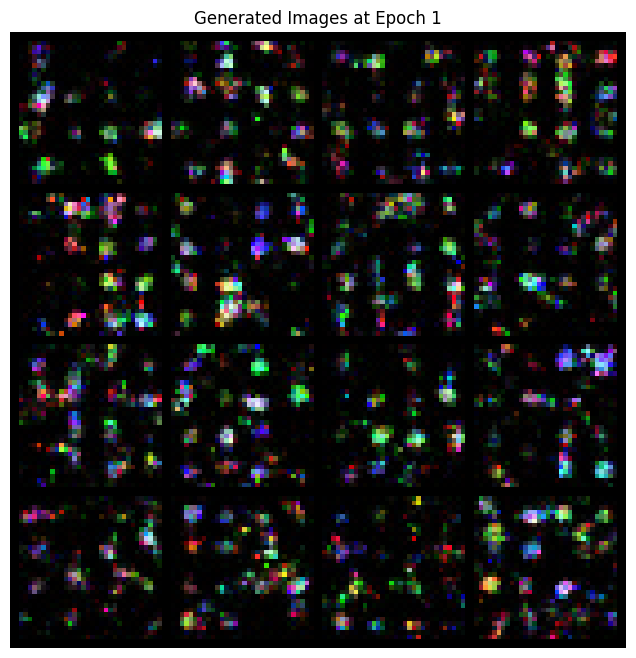

2025-07-07 10:32:00 - INFO - ------------------------------
2025-07-07 10:32:03 - INFO - Epoch: 2/60 | Batch: 0/176 | Loss (NLL): -6954.0186 | BPD: 4.7342
2025-07-07 10:33:47 - INFO - Epoch: 2/60 | Batch: 50/176 | Loss (NLL): -7881.7710 | BPD: 4.2985
2025-07-07 10:35:31 - INFO - Epoch: 2/60 | Batch: 100/176 | Loss (NLL): -8044.3276 | BPD: 4.2222
2025-07-07 10:37:15 - INFO - Epoch: 2/60 | Batch: 150/176 | Loss (NLL): -8747.2197 | BPD: 3.8921
2025-07-07 10:38:06 - INFO - --- Epoch 2 Summary ---
2025-07-07 10:38:06 - INFO - Average Loss: -7963.6470 | Time: 366.14s
2025-07-07 10:38:06 - INFO - Generating sample images...


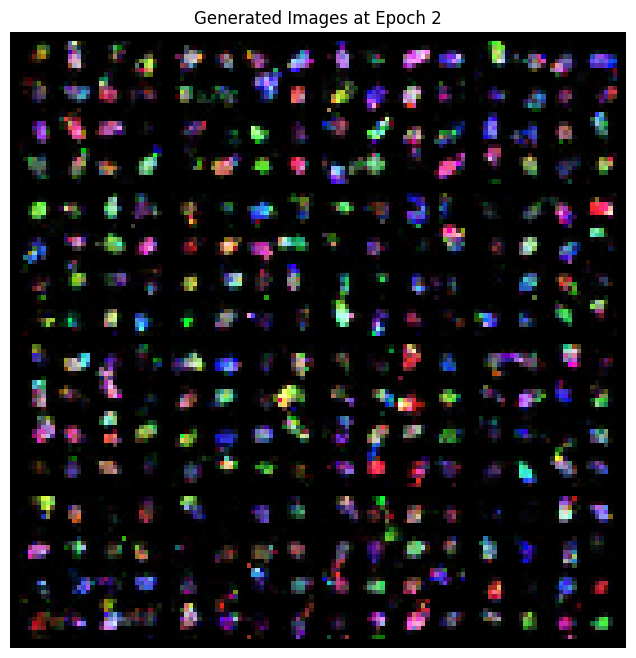

2025-07-07 10:38:06 - INFO - ------------------------------
2025-07-07 10:38:09 - INFO - Epoch: 3/60 | Batch: 0/176 | Loss (NLL): -8843.5410 | BPD: 3.8468
2025-07-07 10:39:53 - INFO - Epoch: 3/60 | Batch: 50/176 | Loss (NLL): -8814.9609 | BPD: 3.8603
2025-07-07 10:41:37 - INFO - Epoch: 3/60 | Batch: 100/176 | Loss (NLL): -9292.8232 | BPD: 3.6358
2025-07-07 10:43:20 - INFO - Epoch: 3/60 | Batch: 150/176 | Loss (NLL): -9319.5361 | BPD: 3.6233
2025-07-07 10:44:12 - INFO - --- Epoch 3 Summary ---
2025-07-07 10:44:12 - INFO - Average Loss: -8987.8493 | Time: 365.28s
2025-07-07 10:44:12 - INFO - Generating sample images...


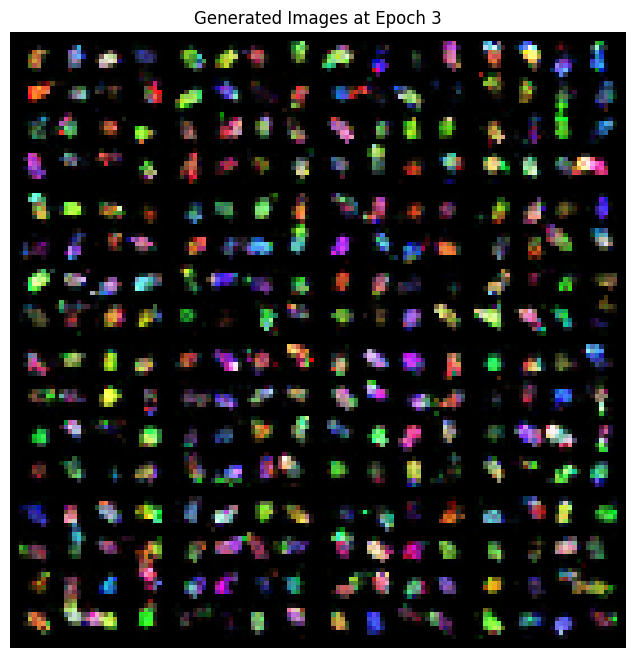

2025-07-07 10:44:12 - INFO - ------------------------------
2025-07-07 10:44:15 - INFO - Epoch: 4/60 | Batch: 0/176 | Loss (NLL): -9314.6104 | BPD: 3.6256
2025-07-07 10:45:59 - INFO - Epoch: 4/60 | Batch: 50/176 | Loss (NLL): -9154.9766 | BPD: 3.7006
2025-07-07 10:47:43 - INFO - Epoch: 4/60 | Batch: 100/176 | Loss (NLL): -9592.3672 | BPD: 3.4952
2025-07-07 10:49:26 - INFO - Epoch: 4/60 | Batch: 150/176 | Loss (NLL): -9444.1270 | BPD: 3.5648
2025-07-07 10:50:17 - INFO - --- Epoch 4 Summary ---
2025-07-07 10:50:17 - INFO - Average Loss: -9467.3858 | Time: 364.73s
2025-07-07 10:50:17 - INFO - Generating sample images...


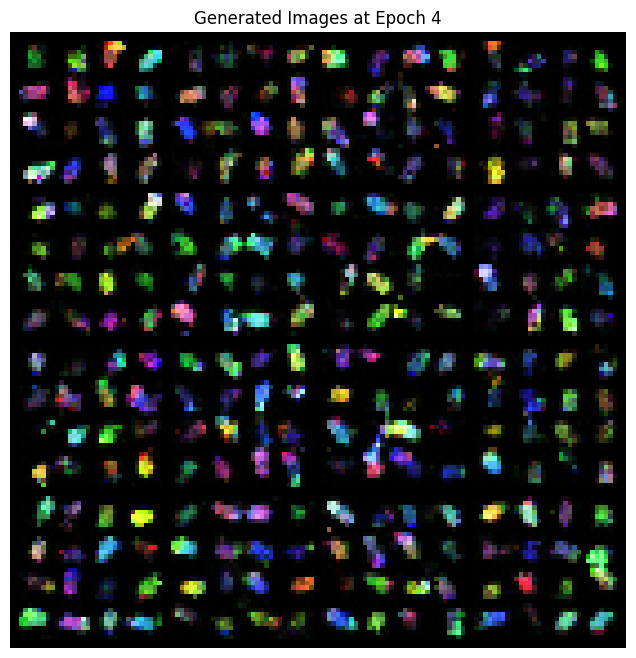

2025-07-07 10:50:17 - INFO - ------------------------------
2025-07-07 10:50:20 - INFO - Epoch: 5/60 | Batch: 0/176 | Loss (NLL): -9633.8906 | BPD: 3.4757
2025-07-07 10:52:04 - INFO - Epoch: 5/60 | Batch: 50/176 | Loss (NLL): -9973.0752 | BPD: 3.3164
2025-07-07 10:53:47 - INFO - Epoch: 5/60 | Batch: 100/176 | Loss (NLL): -10001.1582 | BPD: 3.3032
2025-07-07 10:55:31 - INFO - Epoch: 5/60 | Batch: 150/176 | Loss (NLL): -10091.8799 | BPD: 3.2606
2025-07-07 10:56:24 - INFO - --- Epoch 5 Summary ---
2025-07-07 10:56:24 - INFO - Average Loss: -9904.0808 | Time: 366.35s
2025-07-07 10:56:24 - INFO - Generating sample images...


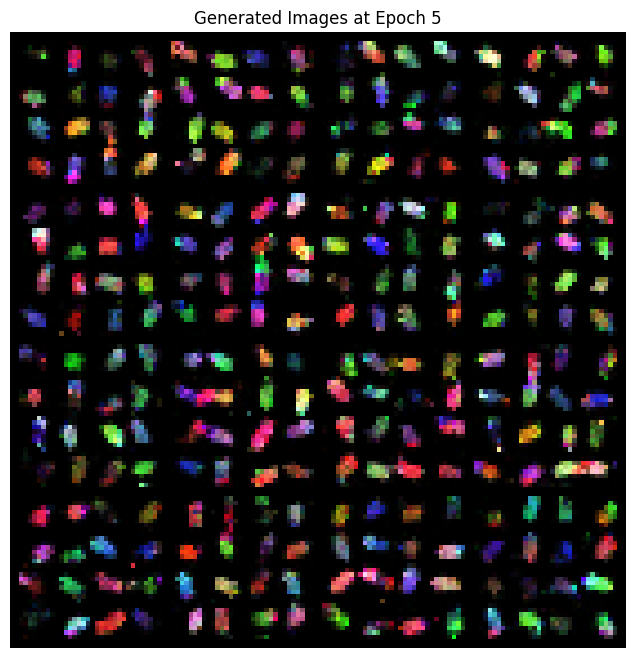

2025-07-07 10:56:24 - INFO - ------------------------------
2025-07-07 10:56:27 - INFO - Epoch: 6/60 | Batch: 0/176 | Loss (NLL): -9808.8672 | BPD: 3.3935
2025-07-07 10:58:11 - INFO - Epoch: 6/60 | Batch: 50/176 | Loss (NLL): -10115.9834 | BPD: 3.2493
2025-07-07 10:59:54 - INFO - Epoch: 6/60 | Batch: 100/176 | Loss (NLL): -10091.0508 | BPD: 3.2610
2025-07-07 11:01:38 - INFO - Epoch: 6/60 | Batch: 150/176 | Loss (NLL): -10386.3428 | BPD: 3.1223
2025-07-07 11:02:29 - INFO - --- Epoch 6 Summary ---
2025-07-07 11:02:29 - INFO - Average Loss: -10103.7860 | Time: 365.36s
2025-07-07 11:02:29 - INFO - Generating sample images...


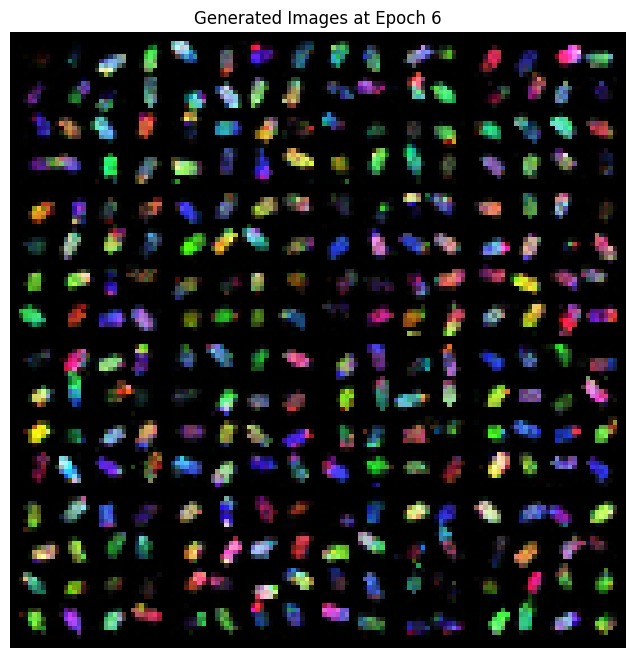

2025-07-07 11:02:30 - INFO - ------------------------------
2025-07-07 11:02:33 - INFO - Epoch: 7/60 | Batch: 0/176 | Loss (NLL): -10376.0654 | BPD: 3.1271
2025-07-07 11:04:16 - INFO - Epoch: 7/60 | Batch: 50/176 | Loss (NLL): -9981.6445 | BPD: 3.3123
2025-07-07 11:05:59 - INFO - Epoch: 7/60 | Batch: 100/176 | Loss (NLL): -10338.1074 | BPD: 3.1449
2025-07-07 11:07:42 - INFO - Epoch: 7/60 | Batch: 150/176 | Loss (NLL): -10670.5762 | BPD: 2.9888
2025-07-07 11:08:34 - INFO - --- Epoch 7 Summary ---
2025-07-07 11:08:34 - INFO - Average Loss: -10399.4520 | Time: 363.72s
2025-07-07 11:08:34 - INFO - Generating sample images...


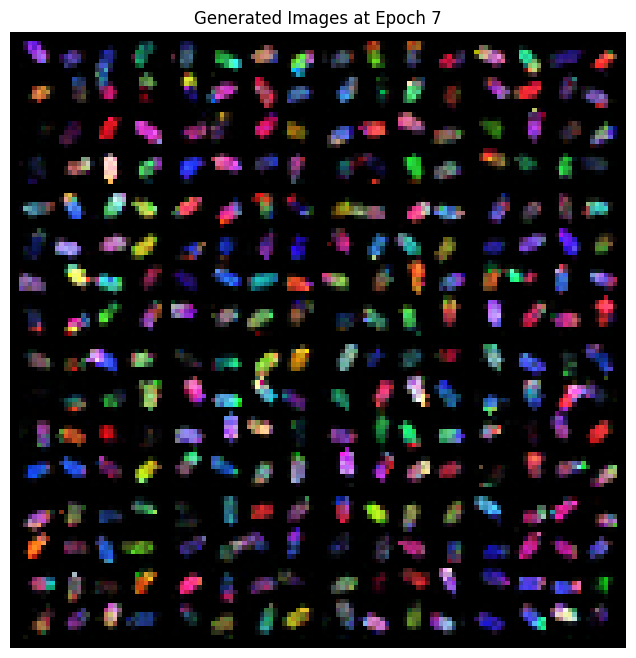

2025-07-07 11:08:34 - INFO - ------------------------------
2025-07-07 11:08:37 - INFO - Epoch: 8/60 | Batch: 0/176 | Loss (NLL): -10633.6992 | BPD: 3.0061
2025-07-07 11:10:21 - INFO - Epoch: 8/60 | Batch: 50/176 | Loss (NLL): -10589.9775 | BPD: 3.0267
2025-07-07 11:12:04 - INFO - Epoch: 8/60 | Batch: 100/176 | Loss (NLL): -10504.1934 | BPD: 3.0669
2025-07-07 11:13:47 - INFO - Epoch: 8/60 | Batch: 150/176 | Loss (NLL): -10470.7754 | BPD: 3.0826
2025-07-07 11:14:39 - INFO - --- Epoch 8 Summary ---
2025-07-07 11:14:39 - INFO - Average Loss: -10622.6546 | Time: 364.80s
2025-07-07 11:14:39 - INFO - Generating sample images...


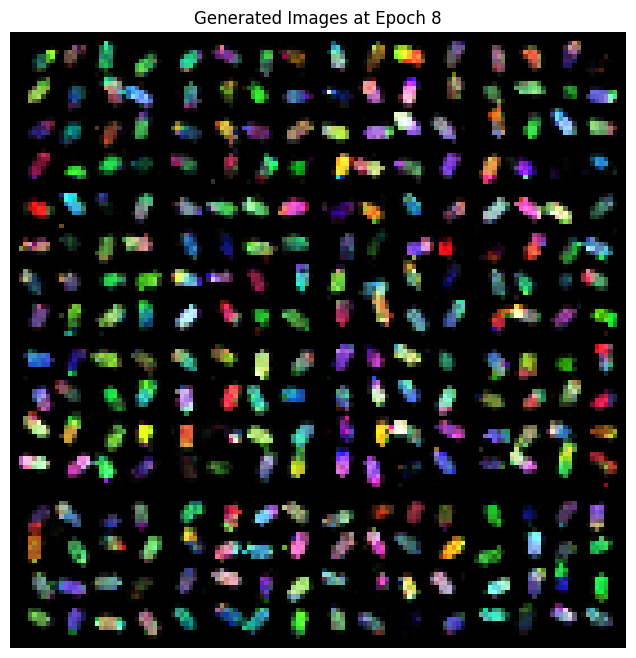

2025-07-07 11:14:39 - INFO - ------------------------------
2025-07-07 11:14:42 - INFO - Epoch: 9/60 | Batch: 0/176 | Loss (NLL): -10676.7031 | BPD: 2.9859
2025-07-07 11:16:26 - INFO - Epoch: 9/60 | Batch: 50/176 | Loss (NLL): -10708.0293 | BPD: 2.9712
2025-07-07 11:18:09 - INFO - Epoch: 9/60 | Batch: 100/176 | Loss (NLL): -10500.9609 | BPD: 3.0685
2025-07-07 11:19:52 - INFO - Epoch: 9/60 | Batch: 150/176 | Loss (NLL): -11047.4844 | BPD: 2.8118
2025-07-07 11:20:44 - INFO - --- Epoch 9 Summary ---
2025-07-07 11:20:44 - INFO - Average Loss: -10771.4797 | Time: 364.64s
2025-07-07 11:20:44 - INFO - Generating sample images...


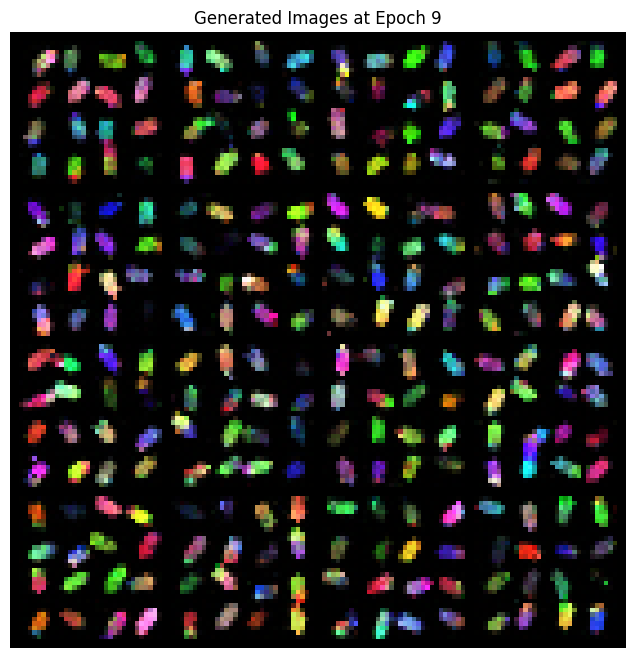

2025-07-07 11:20:44 - INFO - ------------------------------
2025-07-07 11:20:47 - INFO - Epoch: 10/60 | Batch: 0/176 | Loss (NLL): -10913.7598 | BPD: 2.8746
2025-07-07 11:22:32 - INFO - Epoch: 10/60 | Batch: 50/176 | Loss (NLL): -10630.6406 | BPD: 3.0076
2025-07-07 11:24:15 - INFO - Epoch: 10/60 | Batch: 100/176 | Loss (NLL): -10964.2246 | BPD: 2.8509
2025-07-07 11:25:58 - INFO - Epoch: 10/60 | Batch: 150/176 | Loss (NLL): -11135.1396 | BPD: 2.7706
2025-07-07 11:26:50 - INFO - --- Epoch 10 Summary ---
2025-07-07 11:26:50 - INFO - Average Loss: -10892.7779 | Time: 365.57s
2025-07-07 11:26:50 - INFO - Generating sample images...


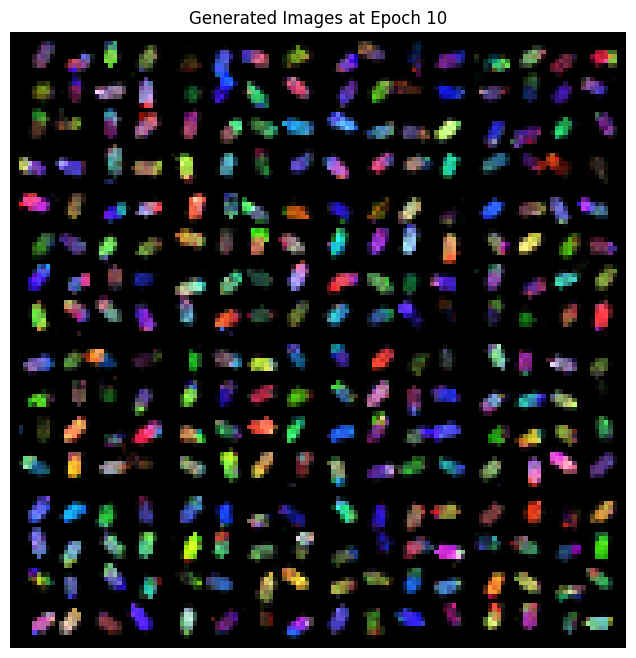

2025-07-07 11:26:50 - INFO - ------------------------------
2025-07-07 11:26:54 - INFO - Epoch: 11/60 | Batch: 0/176 | Loss (NLL): -10826.8516 | BPD: 2.9154
2025-07-07 11:28:37 - INFO - Epoch: 11/60 | Batch: 50/176 | Loss (NLL): -10885.1562 | BPD: 2.8880
2025-07-07 11:30:21 - INFO - Epoch: 11/60 | Batch: 100/176 | Loss (NLL): -11090.4551 | BPD: 2.7916
2025-07-07 11:32:04 - INFO - Epoch: 11/60 | Batch: 150/176 | Loss (NLL): -11342.2568 | BPD: 2.6734
2025-07-07 11:32:56 - INFO - --- Epoch 11 Summary ---
2025-07-07 11:32:56 - INFO - Average Loss: -11015.1028 | Time: 365.63s
2025-07-07 11:32:56 - INFO - Generating sample images...


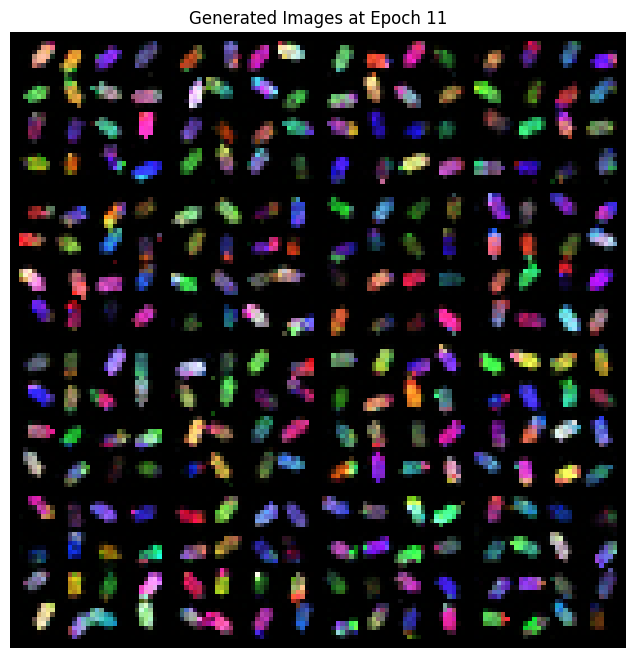

2025-07-07 11:32:57 - INFO - ------------------------------
2025-07-07 11:32:59 - INFO - Epoch: 12/60 | Batch: 0/176 | Loss (NLL): -11346.0488 | BPD: 2.6716
2025-07-07 11:34:43 - INFO - Epoch: 12/60 | Batch: 50/176 | Loss (NLL): -11186.6279 | BPD: 2.7465
2025-07-07 11:36:26 - INFO - Epoch: 12/60 | Batch: 100/176 | Loss (NLL): -11065.6133 | BPD: 2.8033
2025-07-07 11:38:10 - INFO - Epoch: 12/60 | Batch: 150/176 | Loss (NLL): -11370.2588 | BPD: 2.6602
2025-07-07 11:39:01 - INFO - --- Epoch 12 Summary ---
2025-07-07 11:39:01 - INFO - Average Loss: -11139.3767 | Time: 364.95s
2025-07-07 11:39:01 - INFO - Generating sample images...


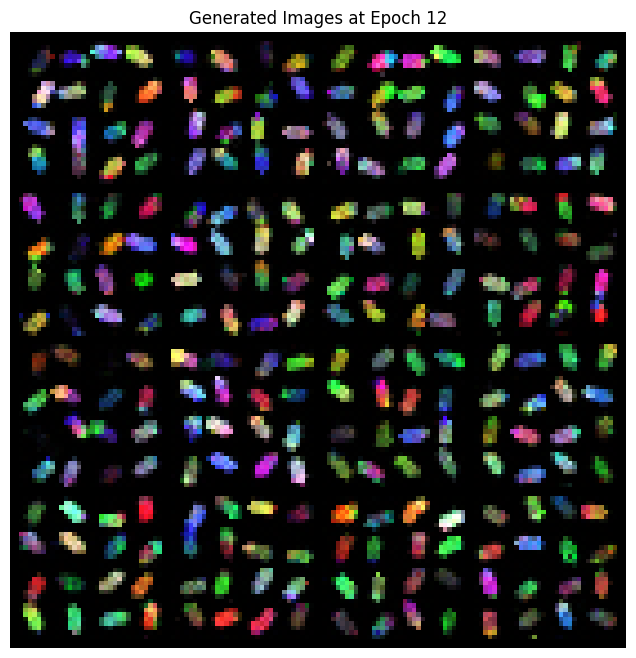

2025-07-07 11:39:02 - INFO - ------------------------------
2025-07-07 11:39:05 - INFO - Epoch: 13/60 | Batch: 0/176 | Loss (NLL): -10946.5430 | BPD: 2.8592
2025-07-07 11:40:49 - INFO - Epoch: 13/60 | Batch: 50/176 | Loss (NLL): -11279.8867 | BPD: 2.7027
2025-07-07 11:42:32 - INFO - Epoch: 13/60 | Batch: 100/176 | Loss (NLL): -11113.9609 | BPD: 2.7806
2025-07-07 11:44:16 - INFO - Epoch: 13/60 | Batch: 150/176 | Loss (NLL): -11107.9199 | BPD: 2.7834
2025-07-07 11:45:08 - INFO - --- Epoch 13 Summary ---
2025-07-07 11:45:08 - INFO - Average Loss: -11248.8862 | Time: 365.89s
2025-07-07 11:45:08 - INFO - Generating sample images...


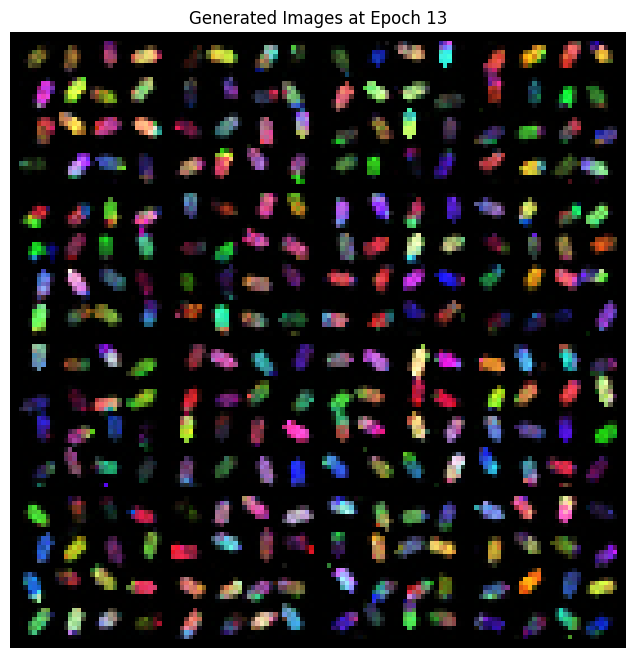

2025-07-07 11:45:08 - INFO - ------------------------------
2025-07-07 11:45:11 - INFO - Epoch: 14/60 | Batch: 0/176 | Loss (NLL): -11440.5605 | BPD: 2.6272
2025-07-07 11:46:55 - INFO - Epoch: 14/60 | Batch: 50/176 | Loss (NLL): -11277.2539 | BPD: 2.7039
2025-07-07 11:48:38 - INFO - Epoch: 14/60 | Batch: 100/176 | Loss (NLL): -11416.1074 | BPD: 2.6387
2025-07-07 11:50:22 - INFO - Epoch: 14/60 | Batch: 150/176 | Loss (NLL): -11270.8330 | BPD: 2.7069
2025-07-07 11:51:13 - INFO - --- Epoch 14 Summary ---
2025-07-07 11:51:13 - INFO - Average Loss: -11323.5473 | Time: 364.97s
2025-07-07 11:51:13 - INFO - Generating sample images...


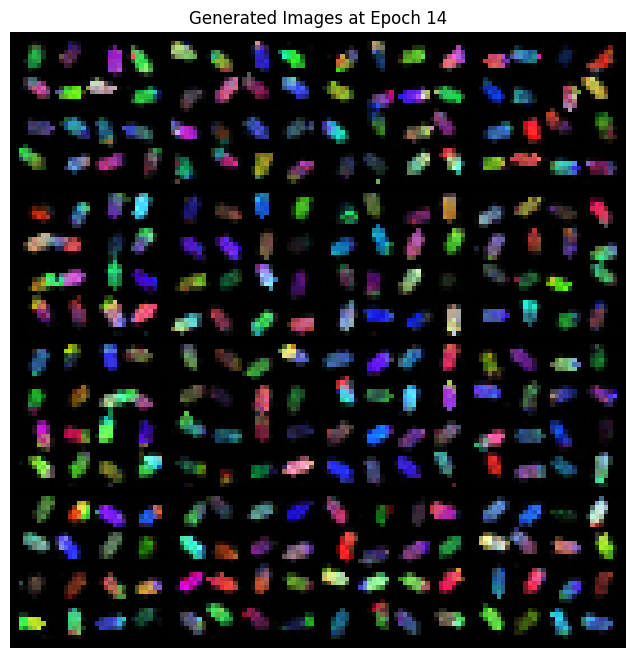

2025-07-07 11:51:14 - INFO - ------------------------------
2025-07-07 11:51:17 - INFO - Epoch: 15/60 | Batch: 0/176 | Loss (NLL): -11087.9795 | BPD: 2.7928
2025-07-07 11:53:00 - INFO - Epoch: 15/60 | Batch: 50/176 | Loss (NLL): -11279.9561 | BPD: 2.7026
2025-07-07 11:54:44 - INFO - Epoch: 15/60 | Batch: 100/176 | Loss (NLL): -11375.0957 | BPD: 2.6579
2025-07-07 11:56:28 - INFO - Epoch: 15/60 | Batch: 150/176 | Loss (NLL): -11534.4355 | BPD: 2.5831
2025-07-07 11:57:20 - INFO - --- Epoch 15 Summary ---
2025-07-07 11:57:20 - INFO - Average Loss: -11355.0319 | Time: 366.01s
2025-07-07 11:57:20 - INFO - Generating sample images...


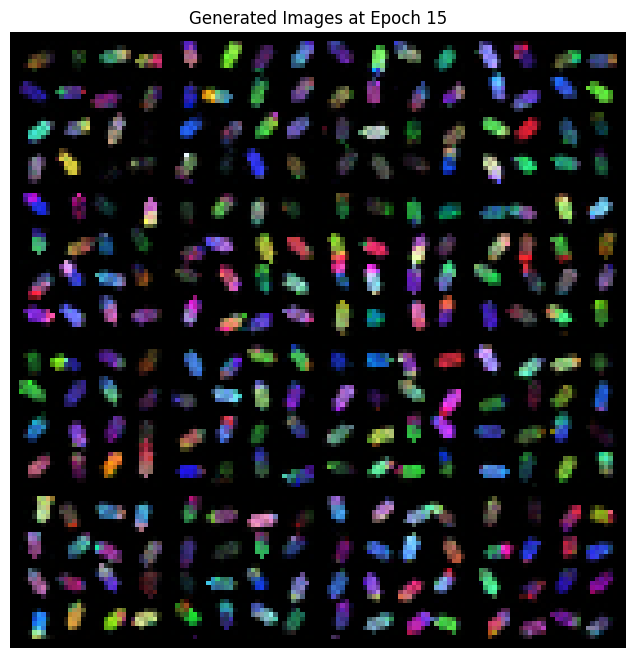

2025-07-07 11:57:20 - INFO - ------------------------------
2025-07-07 11:57:23 - INFO - Epoch: 16/60 | Batch: 0/176 | Loss (NLL): -11581.3242 | BPD: 2.5611
2025-07-07 11:59:07 - INFO - Epoch: 16/60 | Batch: 50/176 | Loss (NLL): -11636.1289 | BPD: 2.5354
2025-07-07 12:00:51 - INFO - Epoch: 16/60 | Batch: 100/176 | Loss (NLL): -11333.5215 | BPD: 2.6775
2025-07-07 12:02:34 - INFO - Epoch: 16/60 | Batch: 150/176 | Loss (NLL): -11735.3633 | BPD: 2.4888
2025-07-07 12:03:26 - INFO - --- Epoch 16 Summary ---
2025-07-07 12:03:26 - INFO - Average Loss: -11525.4152 | Time: 365.42s
2025-07-07 12:03:26 - INFO - Generating sample images...


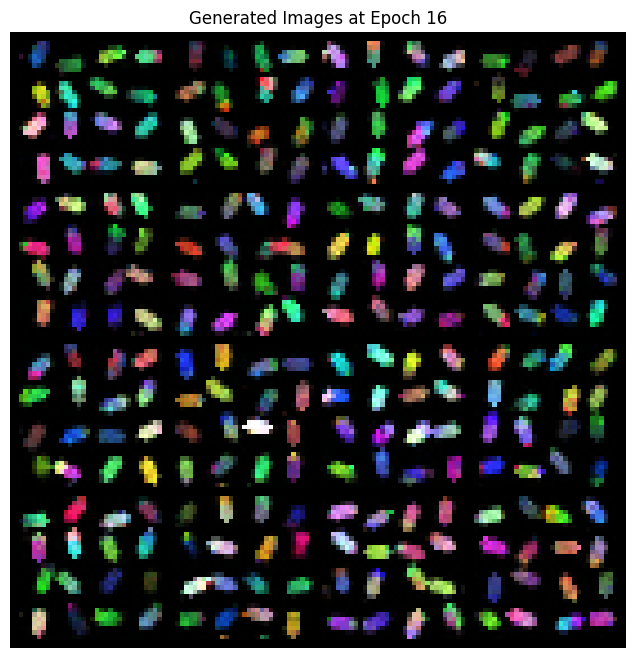

2025-07-07 12:03:26 - INFO - ------------------------------
2025-07-07 12:03:29 - INFO - Epoch: 17/60 | Batch: 0/176 | Loss (NLL): -11559.3584 | BPD: 2.5714
2025-07-07 12:05:13 - INFO - Epoch: 17/60 | Batch: 50/176 | Loss (NLL): -11542.3916 | BPD: 2.5794
2025-07-07 12:06:58 - INFO - Epoch: 17/60 | Batch: 100/176 | Loss (NLL): -11702.7129 | BPD: 2.5041
2025-07-07 12:08:42 - INFO - Epoch: 17/60 | Batch: 150/176 | Loss (NLL): -11796.2285 | BPD: 2.4602
2025-07-07 12:09:34 - INFO - --- Epoch 17 Summary ---
2025-07-07 12:09:34 - INFO - Average Loss: -11559.9348 | Time: 367.65s
2025-07-07 12:09:34 - INFO - Generating sample images...


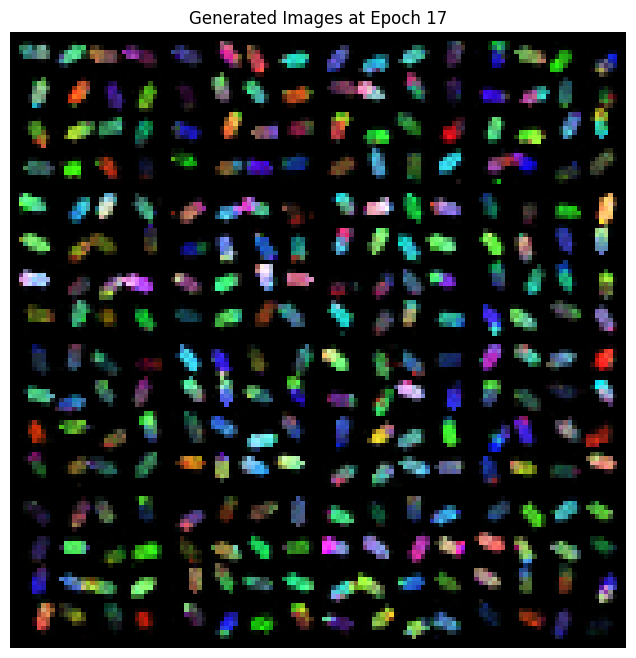

2025-07-07 12:09:34 - INFO - ------------------------------
2025-07-07 12:09:37 - INFO - Epoch: 18/60 | Batch: 0/176 | Loss (NLL): -11562.8330 | BPD: 2.5698
2025-07-07 12:11:21 - INFO - Epoch: 18/60 | Batch: 50/176 | Loss (NLL): -11684.1279 | BPD: 2.5128
2025-07-07 12:13:05 - INFO - Epoch: 18/60 | Batch: 100/176 | Loss (NLL): -11766.9609 | BPD: 2.4739
2025-07-07 12:14:50 - INFO - Epoch: 18/60 | Batch: 150/176 | Loss (NLL): -11541.0811 | BPD: 2.5800
2025-07-07 12:15:42 - INFO - --- Epoch 18 Summary ---
2025-07-07 12:15:42 - INFO - Average Loss: -11605.9603 | Time: 368.25s
2025-07-07 12:15:42 - INFO - Generating sample images...


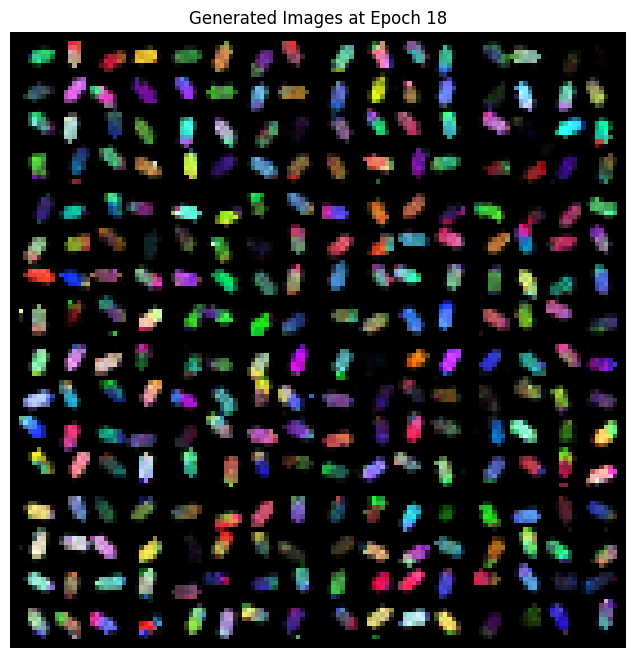

2025-07-07 12:15:43 - INFO - ------------------------------
2025-07-07 12:15:46 - INFO - Epoch: 19/60 | Batch: 0/176 | Loss (NLL): -11808.5508 | BPD: 2.4544
2025-07-07 12:17:30 - INFO - Epoch: 19/60 | Batch: 50/176 | Loss (NLL): -11541.2168 | BPD: 2.5799
2025-07-07 12:19:14 - INFO - Epoch: 19/60 | Batch: 100/176 | Loss (NLL): -11496.3594 | BPD: 2.6010
2025-07-07 12:20:59 - INFO - Epoch: 19/60 | Batch: 150/176 | Loss (NLL): -11678.3613 | BPD: 2.5155
2025-07-07 12:21:51 - INFO - --- Epoch 19 Summary ---
2025-07-07 12:21:51 - INFO - Average Loss: -11716.5874 | Time: 368.23s
2025-07-07 12:21:51 - INFO - Generating sample images...


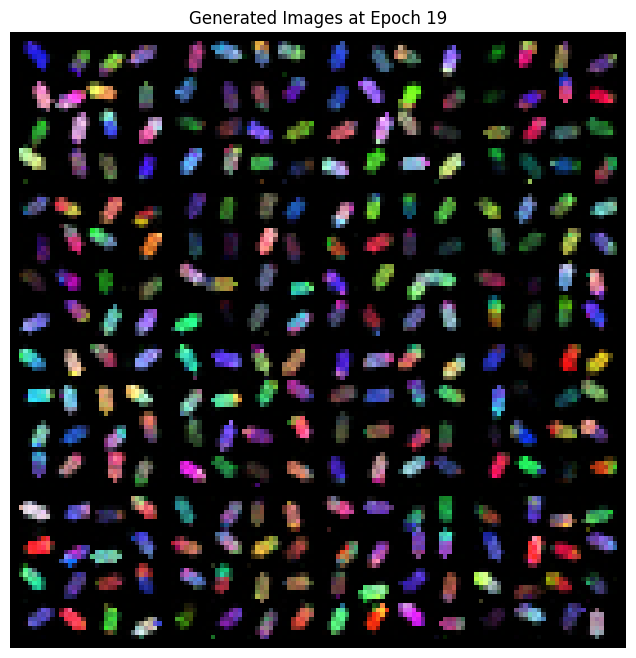

2025-07-07 12:21:52 - INFO - ------------------------------
2025-07-07 12:21:55 - INFO - Epoch: 20/60 | Batch: 0/176 | Loss (NLL): -11710.2822 | BPD: 2.5005
2025-07-07 12:23:39 - INFO - Epoch: 20/60 | Batch: 50/176 | Loss (NLL): -11743.9609 | BPD: 2.4847
2025-07-07 12:25:23 - INFO - Epoch: 20/60 | Batch: 100/176 | Loss (NLL): -11706.2822 | BPD: 2.5024
2025-07-07 12:27:07 - INFO - Epoch: 20/60 | Batch: 150/176 | Loss (NLL): -11882.4062 | BPD: 2.4197
2025-07-07 12:27:58 - INFO - --- Epoch 20 Summary ---
2025-07-07 12:27:58 - INFO - Average Loss: -11749.6313 | Time: 366.71s
2025-07-07 12:27:58 - INFO - Generating sample images...


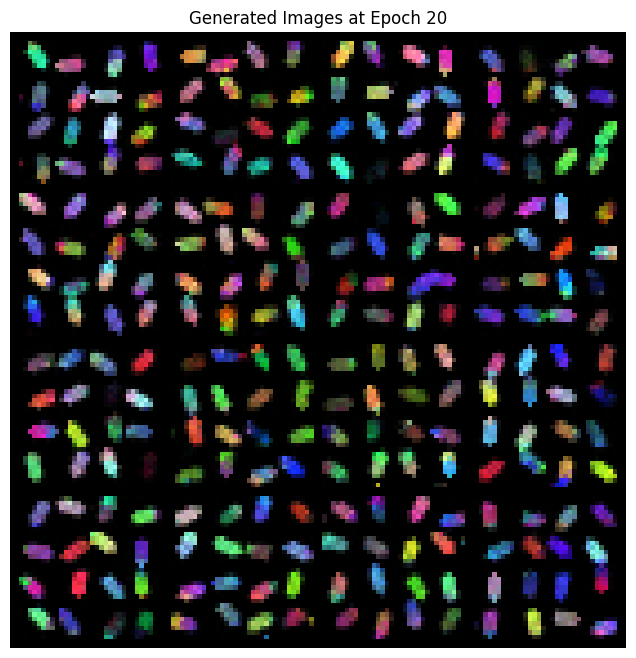

2025-07-07 12:27:59 - INFO - ------------------------------
2025-07-07 12:28:02 - INFO - Epoch: 21/60 | Batch: 0/176 | Loss (NLL): -11964.0986 | BPD: 2.3813
2025-07-07 12:29:46 - INFO - Epoch: 21/60 | Batch: 50/176 | Loss (NLL): -11878.5928 | BPD: 2.4215
2025-07-07 12:31:30 - INFO - Epoch: 21/60 | Batch: 100/176 | Loss (NLL): -11976.0098 | BPD: 2.3757
2025-07-07 12:33:14 - INFO - Epoch: 21/60 | Batch: 150/176 | Loss (NLL): -12103.5615 | BPD: 2.3158
2025-07-07 12:34:06 - INFO - --- Epoch 21 Summary ---
2025-07-07 12:34:06 - INFO - Average Loss: -11829.5450 | Time: 367.02s
2025-07-07 12:34:06 - INFO - Generating sample images...


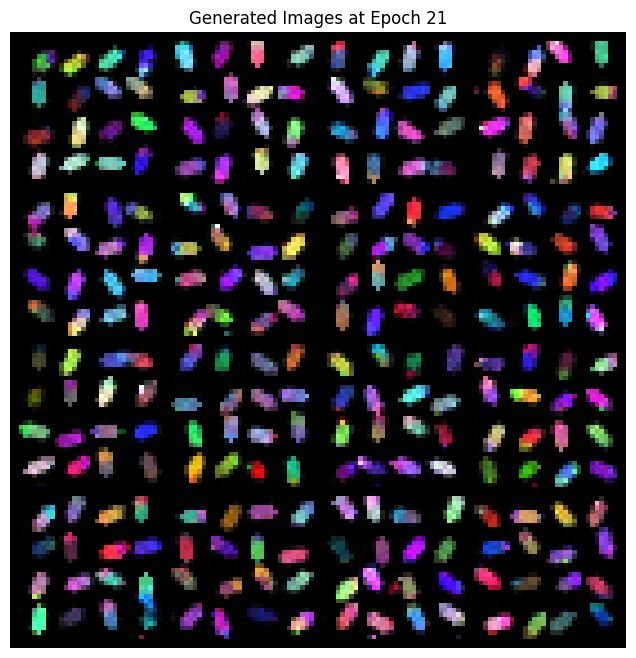

2025-07-07 12:34:06 - INFO - ------------------------------
2025-07-07 12:34:09 - INFO - Epoch: 22/60 | Batch: 0/176 | Loss (NLL): -11624.8066 | BPD: 2.5407
2025-07-07 12:35:54 - INFO - Epoch: 22/60 | Batch: 50/176 | Loss (NLL): -11726.5205 | BPD: 2.4929
2025-07-07 12:37:38 - INFO - Epoch: 22/60 | Batch: 100/176 | Loss (NLL): -12014.9238 | BPD: 2.3575
2025-07-07 12:39:23 - INFO - Epoch: 22/60 | Batch: 150/176 | Loss (NLL): -12120.7188 | BPD: 2.3078
2025-07-07 12:40:15 - INFO - --- Epoch 22 Summary ---
2025-07-07 12:40:15 - INFO - Average Loss: -11906.9944 | Time: 368.68s
2025-07-07 12:40:15 - INFO - Generating sample images...


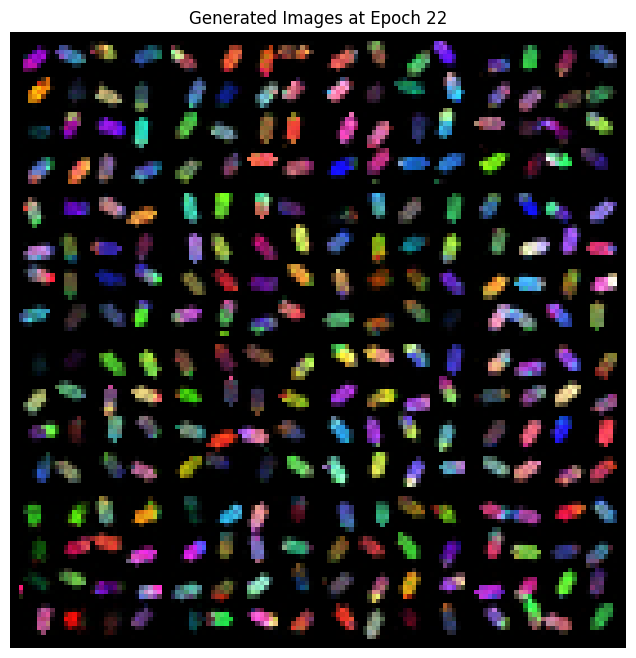

2025-07-07 12:40:16 - INFO - ------------------------------
2025-07-07 12:40:19 - INFO - Epoch: 23/60 | Batch: 0/176 | Loss (NLL): -11704.0176 | BPD: 2.5035
2025-07-07 12:42:03 - INFO - Epoch: 23/60 | Batch: 50/176 | Loss (NLL): -12062.2441 | BPD: 2.3352
2025-07-07 12:43:48 - INFO - Epoch: 23/60 | Batch: 100/176 | Loss (NLL): -12009.5020 | BPD: 2.3600
2025-07-07 12:45:32 - INFO - Epoch: 23/60 | Batch: 150/176 | Loss (NLL): -11920.4512 | BPD: 2.4018
2025-07-07 12:46:24 - INFO - --- Epoch 23 Summary ---
2025-07-07 12:46:24 - INFO - Average Loss: -11972.4728 | Time: 368.71s
2025-07-07 12:46:24 - INFO - Generating sample images...


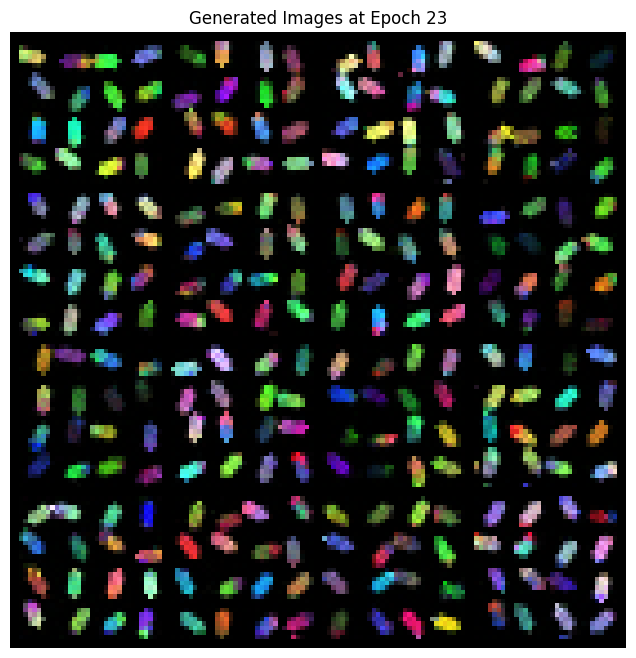

2025-07-07 12:46:25 - INFO - ------------------------------
2025-07-07 12:46:28 - INFO - Epoch: 24/60 | Batch: 0/176 | Loss (NLL): -11936.6504 | BPD: 2.3942
2025-07-07 12:48:13 - INFO - Epoch: 24/60 | Batch: 50/176 | Loss (NLL): -11701.6768 | BPD: 2.5046
2025-07-07 12:49:57 - INFO - Epoch: 24/60 | Batch: 100/176 | Loss (NLL): -12049.0840 | BPD: 2.3414
2025-07-07 12:51:41 - INFO - Epoch: 24/60 | Batch: 150/176 | Loss (NLL): -12012.1191 | BPD: 2.3588
2025-07-07 12:52:33 - INFO - --- Epoch 24 Summary ---
2025-07-07 12:52:33 - INFO - Average Loss: -11945.0163 | Time: 368.07s
2025-07-07 12:52:33 - INFO - Generating sample images...


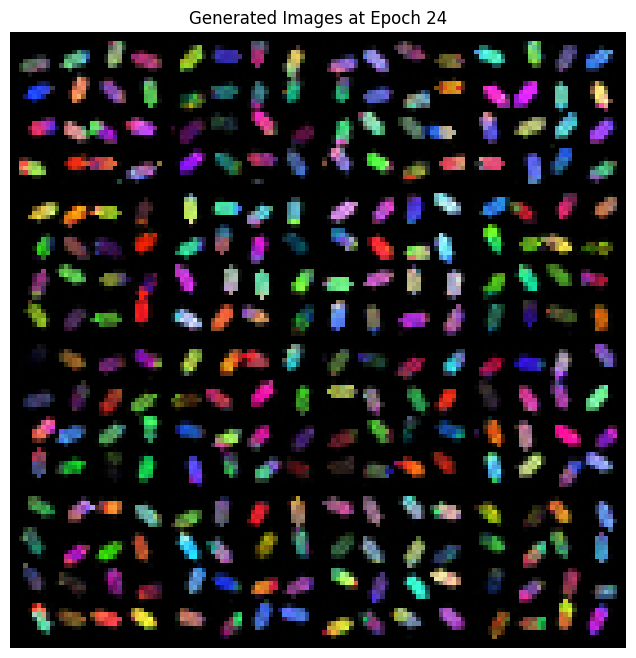

2025-07-07 12:52:33 - INFO - ------------------------------
2025-07-07 12:52:37 - INFO - Epoch: 25/60 | Batch: 0/176 | Loss (NLL): -12047.2773 | BPD: 2.3423
2025-07-07 12:54:21 - INFO - Epoch: 25/60 | Batch: 50/176 | Loss (NLL): -12129.7471 | BPD: 2.3035
2025-07-07 12:56:05 - INFO - Epoch: 25/60 | Batch: 100/176 | Loss (NLL): -12145.6709 | BPD: 2.2961
2025-07-07 12:57:50 - INFO - Epoch: 25/60 | Batch: 150/176 | Loss (NLL): -11675.3750 | BPD: 2.5169
2025-07-07 12:58:42 - INFO - --- Epoch 25 Summary ---
2025-07-07 12:58:42 - INFO - Average Loss: -12033.0344 | Time: 368.57s
2025-07-07 12:58:42 - INFO - Generating sample images...


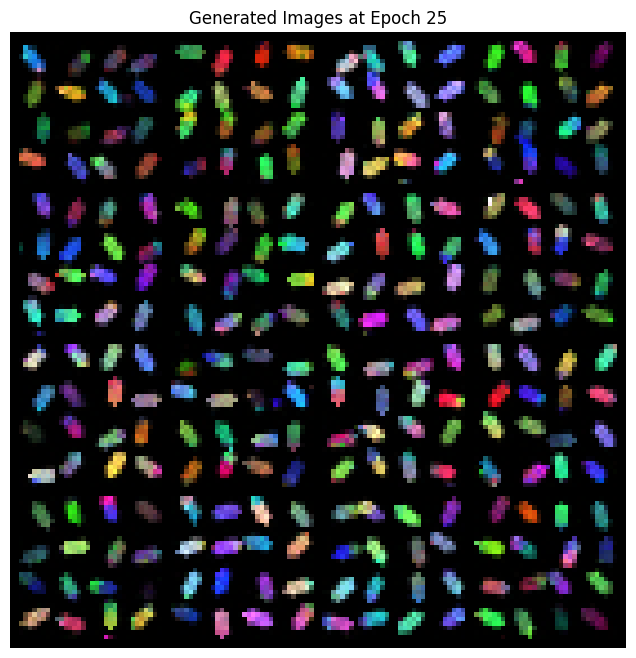

2025-07-07 12:58:42 - INFO - ------------------------------
2025-07-07 12:58:46 - INFO - Epoch: 26/60 | Batch: 0/176 | Loss (NLL): -12362.7461 | BPD: 2.1941
2025-07-07 13:00:30 - INFO - Epoch: 26/60 | Batch: 50/176 | Loss (NLL): -12226.5762 | BPD: 2.2581
2025-07-07 13:02:15 - INFO - Epoch: 26/60 | Batch: 100/176 | Loss (NLL): -11913.0088 | BPD: 2.4053
2025-07-07 13:03:59 - INFO - Epoch: 26/60 | Batch: 150/176 | Loss (NLL): -12097.4238 | BPD: 2.3187
2025-07-07 13:04:51 - INFO - --- Epoch 26 Summary ---
2025-07-07 13:04:51 - INFO - Average Loss: -12090.9506 | Time: 369.01s
2025-07-07 13:04:51 - INFO - Generating sample images...


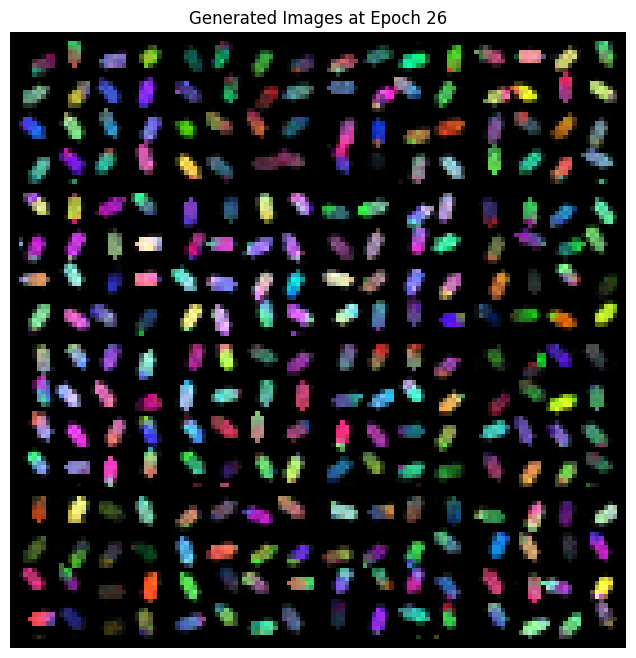

2025-07-07 13:04:52 - INFO - ------------------------------
2025-07-07 13:04:55 - INFO - Epoch: 27/60 | Batch: 0/176 | Loss (NLL): -12214.4102 | BPD: 2.2638
2025-07-07 13:06:39 - INFO - Epoch: 27/60 | Batch: 50/176 | Loss (NLL): -12213.2246 | BPD: 2.2643
2025-07-07 13:08:24 - INFO - Epoch: 27/60 | Batch: 100/176 | Loss (NLL): -12176.6738 | BPD: 2.2815
2025-07-07 13:10:08 - INFO - Epoch: 27/60 | Batch: 150/176 | Loss (NLL): -12261.2930 | BPD: 2.2418
2025-07-07 13:11:00 - INFO - --- Epoch 27 Summary ---
2025-07-07 13:11:00 - INFO - Average Loss: -12106.7142 | Time: 368.26s
2025-07-07 13:11:00 - INFO - Generating sample images...


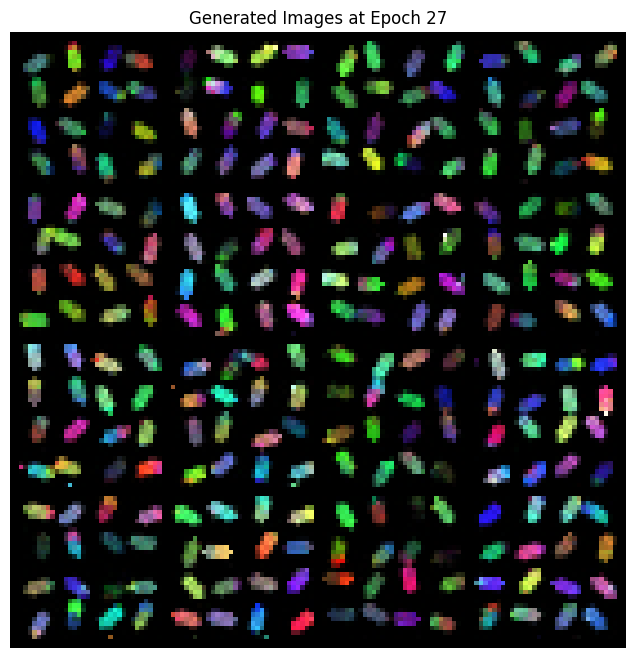

2025-07-07 13:11:01 - INFO - ------------------------------
2025-07-07 13:11:03 - INFO - Epoch: 28/60 | Batch: 0/176 | Loss (NLL): -12361.7012 | BPD: 2.1946
2025-07-07 13:12:48 - INFO - Epoch: 28/60 | Batch: 50/176 | Loss (NLL): -12087.2656 | BPD: 2.3235
2025-07-07 13:14:33 - INFO - Epoch: 28/60 | Batch: 100/176 | Loss (NLL): -12109.7246 | BPD: 2.3129
2025-07-07 13:16:17 - INFO - Epoch: 28/60 | Batch: 150/176 | Loss (NLL): -12172.8340 | BPD: 2.2833
2025-07-07 13:17:09 - INFO - --- Epoch 28 Summary ---
2025-07-07 13:17:09 - INFO - Average Loss: -12156.7436 | Time: 368.73s
2025-07-07 13:17:09 - INFO - Generating sample images...


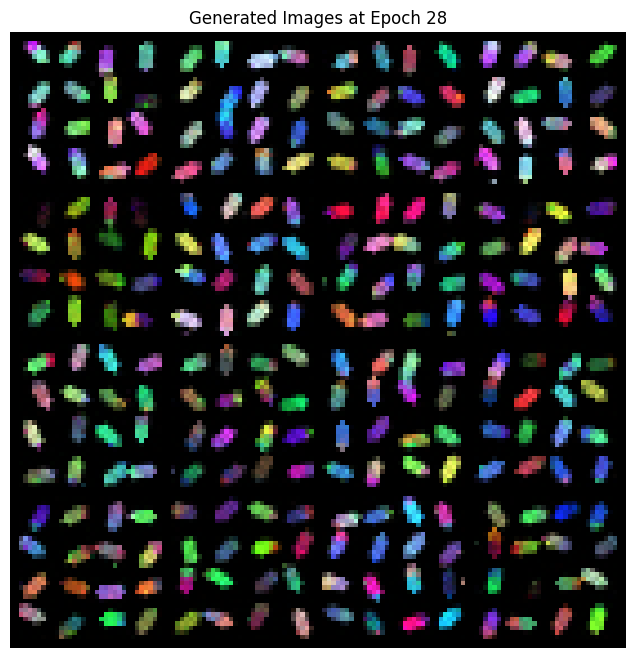

2025-07-07 13:17:10 - INFO - ------------------------------
2025-07-07 13:17:13 - INFO - Epoch: 29/60 | Batch: 0/176 | Loss (NLL): -12097.4453 | BPD: 2.3187
2025-07-07 13:18:57 - INFO - Epoch: 29/60 | Batch: 50/176 | Loss (NLL): -12067.1582 | BPD: 2.3329
2025-07-07 13:20:42 - INFO - Epoch: 29/60 | Batch: 100/176 | Loss (NLL): -12073.0068 | BPD: 2.3302
2025-07-07 13:22:26 - INFO - Epoch: 29/60 | Batch: 150/176 | Loss (NLL): -12439.4238 | BPD: 2.1581
2025-07-07 13:23:18 - INFO - --- Epoch 29 Summary ---
2025-07-07 13:23:18 - INFO - Average Loss: -12199.9737 | Time: 367.90s
2025-07-07 13:23:18 - INFO - Generating sample images...


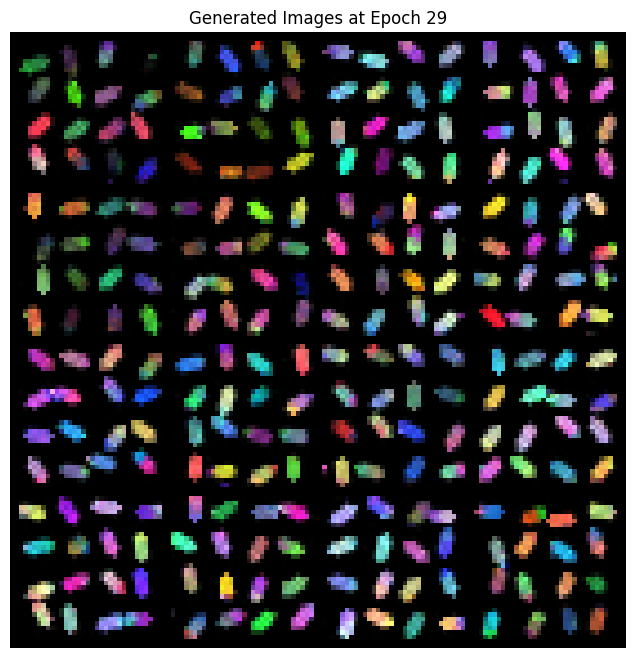

2025-07-07 13:23:18 - INFO - ------------------------------
2025-07-07 13:23:21 - INFO - Epoch: 30/60 | Batch: 0/176 | Loss (NLL): -12359.1914 | BPD: 2.1958
2025-07-07 13:25:05 - INFO - Epoch: 30/60 | Batch: 50/176 | Loss (NLL): -12125.9082 | BPD: 2.3053
2025-07-07 13:26:50 - INFO - Epoch: 30/60 | Batch: 100/176 | Loss (NLL): -12240.9785 | BPD: 2.2513
2025-07-07 13:28:34 - INFO - Epoch: 30/60 | Batch: 150/176 | Loss (NLL): -12244.1797 | BPD: 2.2498
2025-07-07 13:29:26 - INFO - --- Epoch 30 Summary ---
2025-07-07 13:29:26 - INFO - Average Loss: -12221.2400 | Time: 367.54s
2025-07-07 13:29:26 - INFO - Generating sample images...


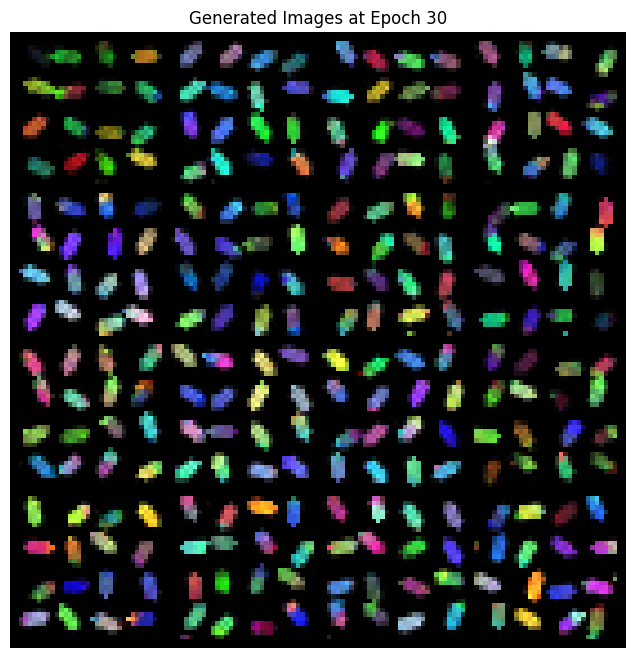

2025-07-07 13:29:26 - INFO - ------------------------------
2025-07-07 13:29:29 - INFO - Epoch: 31/60 | Batch: 0/176 | Loss (NLL): -12343.4990 | BPD: 2.2032
2025-07-07 13:31:14 - INFO - Epoch: 31/60 | Batch: 50/176 | Loss (NLL): -12219.7090 | BPD: 2.2613
2025-07-07 13:32:58 - INFO - Epoch: 31/60 | Batch: 100/176 | Loss (NLL): -11801.1982 | BPD: 2.4578
2025-07-07 13:34:42 - INFO - Epoch: 31/60 | Batch: 150/176 | Loss (NLL): -12405.8086 | BPD: 2.1739
2025-07-07 13:35:34 - INFO - --- Epoch 31 Summary ---
2025-07-07 13:35:34 - INFO - Average Loss: -12308.8102 | Time: 368.26s
2025-07-07 13:35:34 - INFO - Generating sample images...


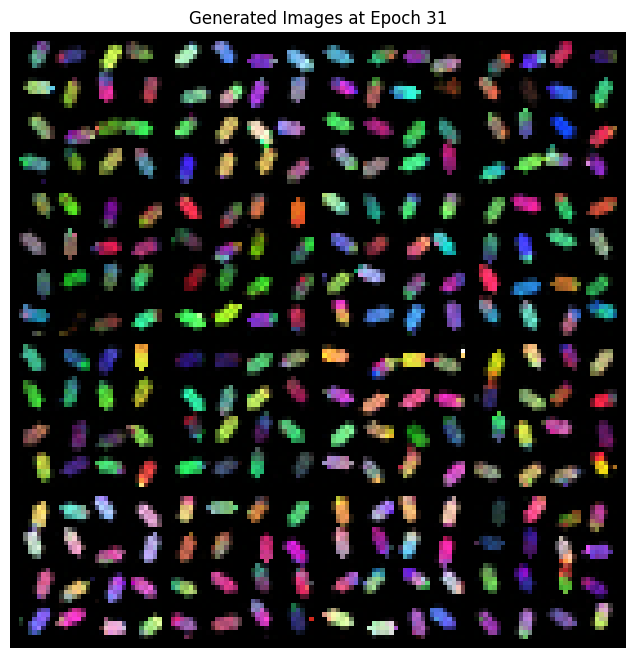

2025-07-07 13:35:35 - INFO - ------------------------------
2025-07-07 13:35:38 - INFO - Epoch: 32/60 | Batch: 0/176 | Loss (NLL): -11823.0273 | BPD: 2.4476
2025-07-07 13:37:23 - INFO - Epoch: 32/60 | Batch: 50/176 | Loss (NLL): -12396.9941 | BPD: 2.1780
2025-07-07 13:39:07 - INFO - Epoch: 32/60 | Batch: 100/176 | Loss (NLL): -12362.4492 | BPD: 2.1943
2025-07-07 13:40:52 - INFO - Epoch: 32/60 | Batch: 150/176 | Loss (NLL): -12402.6543 | BPD: 2.1754
2025-07-07 13:41:44 - INFO - --- Epoch 32 Summary ---
2025-07-07 13:41:44 - INFO - Average Loss: -12248.9042 | Time: 368.82s
2025-07-07 13:41:44 - INFO - Generating sample images...


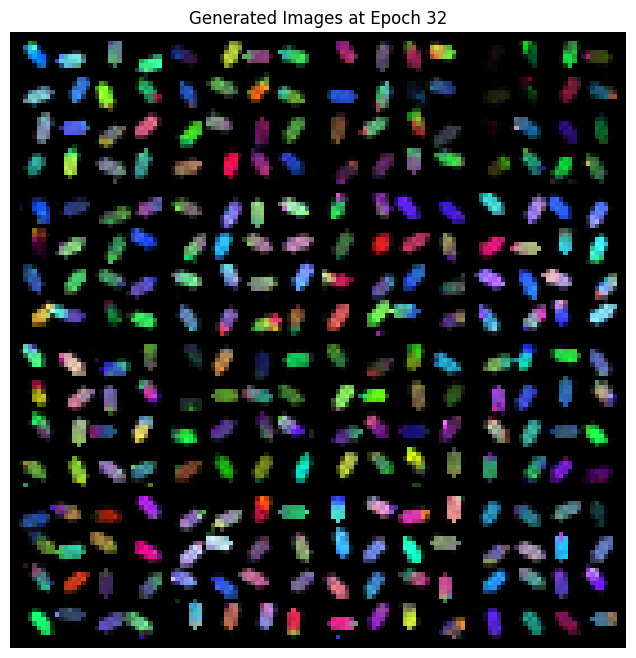

2025-07-07 13:41:44 - INFO - ------------------------------
2025-07-07 13:41:47 - INFO - Epoch: 33/60 | Batch: 0/176 | Loss (NLL): -12381.4375 | BPD: 2.1853
2025-07-07 13:43:32 - INFO - Epoch: 33/60 | Batch: 50/176 | Loss (NLL): -12141.2559 | BPD: 2.2981
2025-07-07 13:45:16 - INFO - Epoch: 33/60 | Batch: 100/176 | Loss (NLL): -12350.0039 | BPD: 2.2001
2025-07-07 13:47:01 - INFO - Epoch: 33/60 | Batch: 150/176 | Loss (NLL): -12301.3203 | BPD: 2.2230
2025-07-07 13:47:53 - INFO - --- Epoch 33 Summary ---
2025-07-07 13:47:53 - INFO - Average Loss: -12325.1239 | Time: 368.86s
2025-07-07 13:47:53 - INFO - Generating sample images...


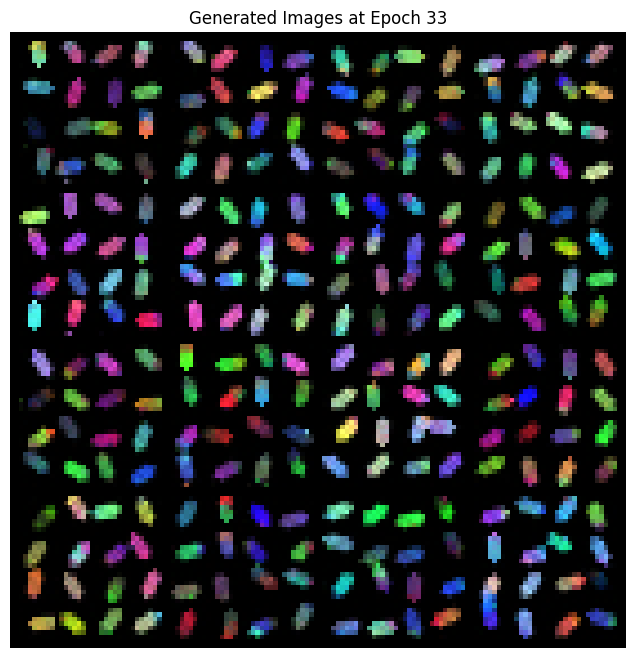

2025-07-07 13:47:53 - INFO - ------------------------------
2025-07-07 13:47:56 - INFO - Epoch: 34/60 | Batch: 0/176 | Loss (NLL): -12605.0947 | BPD: 2.0803
2025-07-07 13:49:41 - INFO - Epoch: 34/60 | Batch: 50/176 | Loss (NLL): -12537.4766 | BPD: 2.1121
2025-07-07 13:51:25 - INFO - Epoch: 34/60 | Batch: 100/176 | Loss (NLL): -12347.9355 | BPD: 2.2011
2025-07-07 13:53:10 - INFO - Epoch: 34/60 | Batch: 150/176 | Loss (NLL): -12090.3379 | BPD: 2.3220
2025-07-07 13:54:02 - INFO - --- Epoch 34 Summary ---
2025-07-07 13:54:02 - INFO - Average Loss: -12367.5899 | Time: 368.33s
2025-07-07 13:54:02 - INFO - Generating sample images...


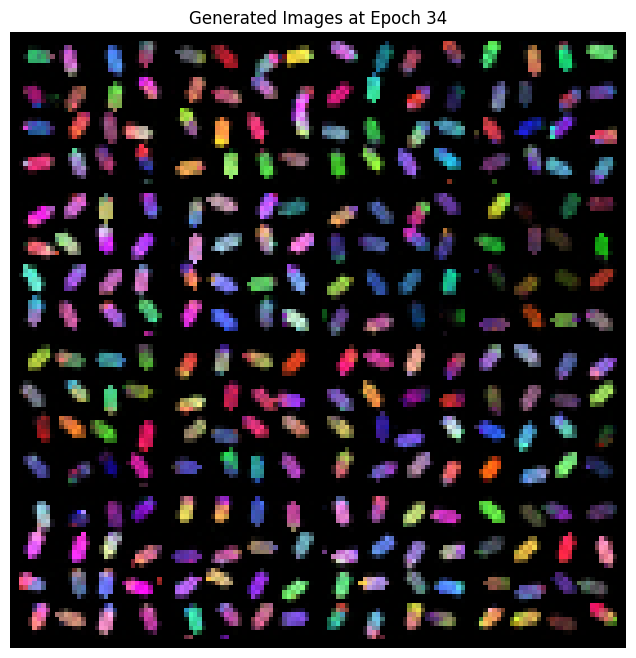

2025-07-07 13:54:02 - INFO - ------------------------------
2025-07-07 13:54:05 - INFO - Epoch: 35/60 | Batch: 0/176 | Loss (NLL): -12125.3887 | BPD: 2.3056
2025-07-07 13:55:50 - INFO - Epoch: 35/60 | Batch: 50/176 | Loss (NLL): -12252.4570 | BPD: 2.2459
2025-07-07 13:57:34 - INFO - Epoch: 35/60 | Batch: 100/176 | Loss (NLL): -12528.9590 | BPD: 2.1161
2025-07-07 13:59:19 - INFO - Epoch: 35/60 | Batch: 150/176 | Loss (NLL): -12504.3135 | BPD: 2.1276
2025-07-07 14:00:10 - INFO - --- Epoch 35 Summary ---
2025-07-07 14:00:10 - INFO - Average Loss: -12382.1844 | Time: 368.13s
2025-07-07 14:00:10 - INFO - Generating sample images...


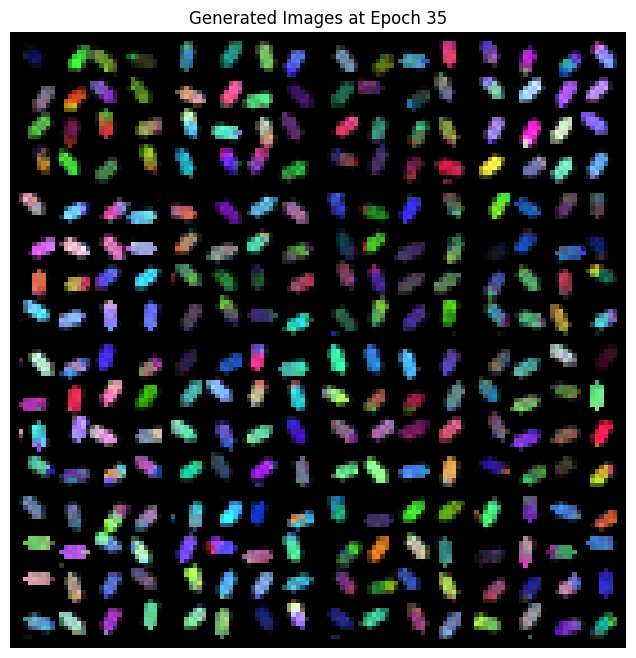

2025-07-07 14:00:11 - INFO - ------------------------------
2025-07-07 14:00:14 - INFO - Epoch: 36/60 | Batch: 0/176 | Loss (NLL): -12336.4531 | BPD: 2.2065
2025-07-07 14:01:58 - INFO - Epoch: 36/60 | Batch: 50/176 | Loss (NLL): -12523.4375 | BPD: 2.1187
2025-07-07 14:03:43 - INFO - Epoch: 36/60 | Batch: 100/176 | Loss (NLL): -12084.8594 | BPD: 2.3246
2025-07-07 14:05:27 - INFO - Epoch: 36/60 | Batch: 150/176 | Loss (NLL): -12568.0205 | BPD: 2.0977
2025-07-07 14:06:19 - INFO - --- Epoch 36 Summary ---
2025-07-07 14:06:19 - INFO - Average Loss: -12428.4018 | Time: 368.39s
2025-07-07 14:06:19 - INFO - Generating sample images...


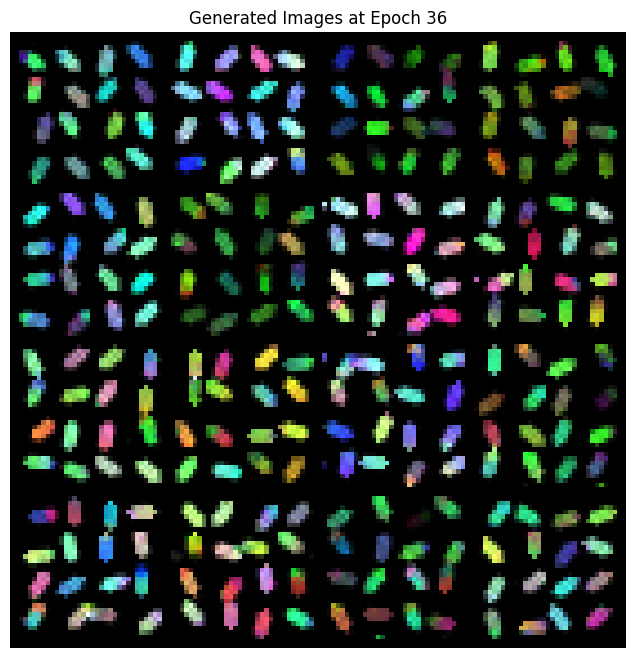

2025-07-07 14:06:20 - INFO - ------------------------------
2025-07-07 14:06:23 - INFO - Epoch: 37/60 | Batch: 0/176 | Loss (NLL): -12127.0518 | BPD: 2.3048
2025-07-07 14:08:07 - INFO - Epoch: 37/60 | Batch: 50/176 | Loss (NLL): -12255.8359 | BPD: 2.2443
2025-07-07 14:09:52 - INFO - Epoch: 37/60 | Batch: 100/176 | Loss (NLL): -12208.2617 | BPD: 2.2667
2025-07-07 14:11:37 - INFO - Epoch: 37/60 | Batch: 150/176 | Loss (NLL): -12543.8730 | BPD: 2.1091
2025-07-07 14:12:29 - INFO - --- Epoch 37 Summary ---
2025-07-07 14:12:29 - INFO - Average Loss: -12447.0262 | Time: 368.82s
2025-07-07 14:12:29 - INFO - Generating sample images...


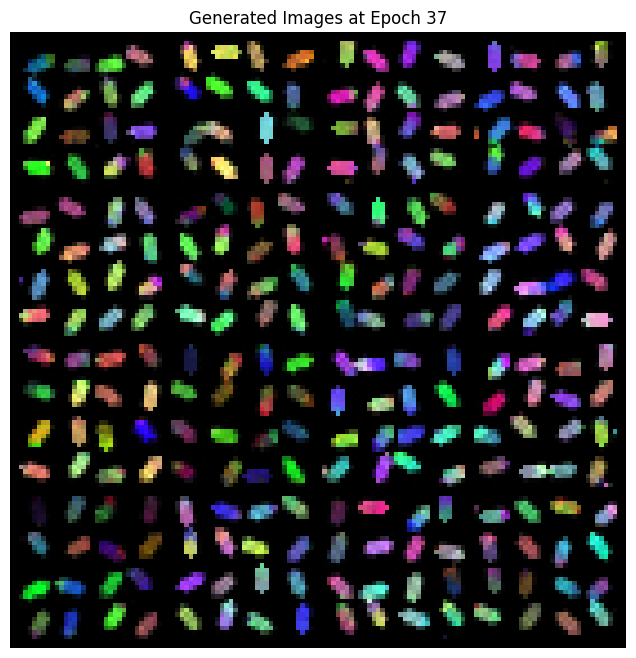

2025-07-07 14:12:29 - INFO - ------------------------------
2025-07-07 14:12:32 - INFO - Epoch: 38/60 | Batch: 0/176 | Loss (NLL): -12568.1621 | BPD: 2.0976
2025-07-07 14:14:17 - INFO - Epoch: 38/60 | Batch: 50/176 | Loss (NLL): -12443.9746 | BPD: 2.1560
2025-07-07 14:16:01 - INFO - Epoch: 38/60 | Batch: 100/176 | Loss (NLL): -12555.9824 | BPD: 2.1034
2025-07-07 14:17:46 - INFO - Epoch: 38/60 | Batch: 150/176 | Loss (NLL): -12360.3008 | BPD: 2.1953
2025-07-07 14:18:38 - INFO - --- Epoch 38 Summary ---
2025-07-07 14:18:38 - INFO - Average Loss: -12474.8919 | Time: 368.69s
2025-07-07 14:18:38 - INFO - Generating sample images...


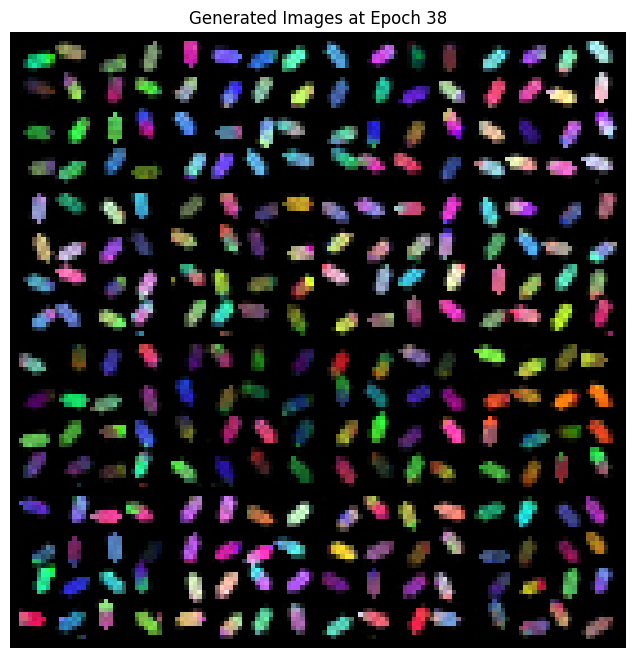

2025-07-07 14:18:38 - INFO - ------------------------------
2025-07-07 14:18:41 - INFO - Epoch: 39/60 | Batch: 0/176 | Loss (NLL): -12525.1260 | BPD: 2.1179
2025-07-07 14:20:26 - INFO - Epoch: 39/60 | Batch: 50/176 | Loss (NLL): -12604.0449 | BPD: 2.0808
2025-07-07 14:22:10 - INFO - Epoch: 39/60 | Batch: 100/176 | Loss (NLL): -12522.1250 | BPD: 2.1193
2025-07-07 14:23:55 - INFO - Epoch: 39/60 | Batch: 150/176 | Loss (NLL): -12743.9727 | BPD: 2.0151
2025-07-07 14:24:47 - INFO - --- Epoch 39 Summary ---
2025-07-07 14:24:47 - INFO - Average Loss: -12547.6184 | Time: 369.20s
2025-07-07 14:24:47 - INFO - Generating sample images...


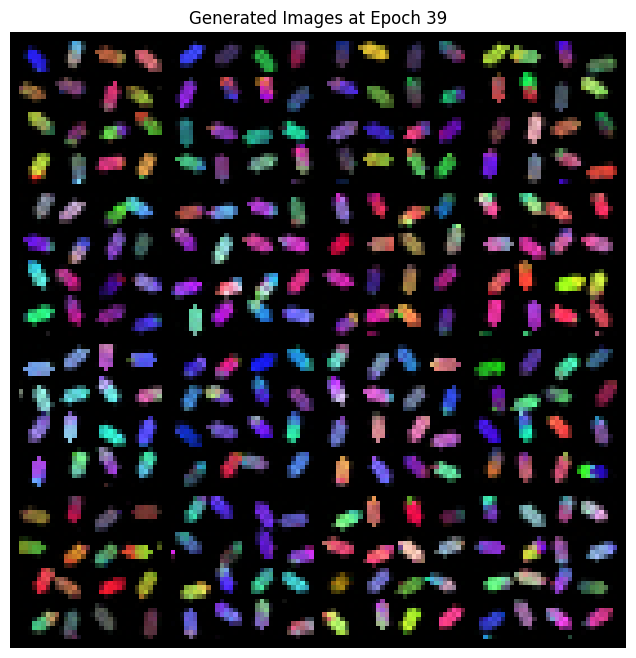

2025-07-07 14:24:48 - INFO - ------------------------------
2025-07-07 14:24:51 - INFO - Epoch: 40/60 | Batch: 0/176 | Loss (NLL): -12690.4707 | BPD: 2.0402
2025-07-07 14:26:35 - INFO - Epoch: 40/60 | Batch: 50/176 | Loss (NLL): -12385.1807 | BPD: 2.1836
2025-07-07 14:28:20 - INFO - Epoch: 40/60 | Batch: 100/176 | Loss (NLL): -12491.9180 | BPD: 2.1335
2025-07-07 14:30:04 - INFO - Epoch: 40/60 | Batch: 150/176 | Loss (NLL): -12236.4385 | BPD: 2.2534
2025-07-07 14:30:57 - INFO - --- Epoch 40 Summary ---
2025-07-07 14:30:57 - INFO - Average Loss: -12538.9913 | Time: 368.90s
2025-07-07 14:30:57 - INFO - Generating sample images...


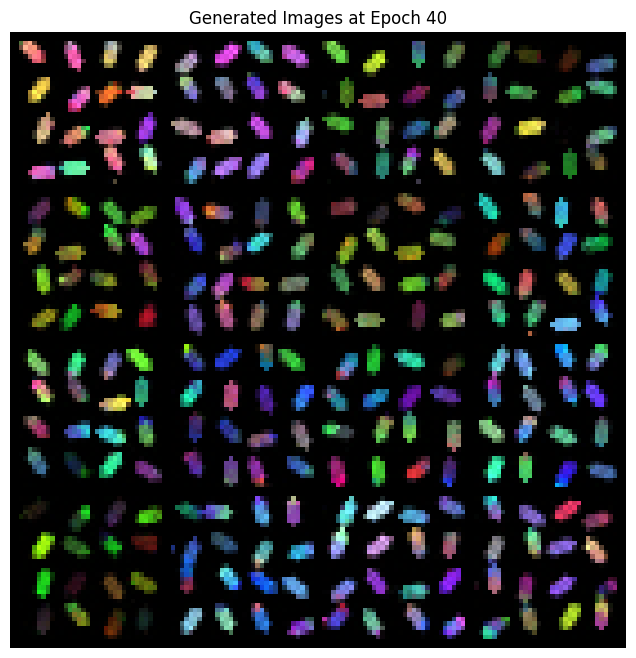

2025-07-07 14:30:57 - INFO - ------------------------------
2025-07-07 14:31:00 - INFO - Epoch: 41/60 | Batch: 0/176 | Loss (NLL): -12704.0645 | BPD: 2.0338
2025-07-07 14:32:45 - INFO - Epoch: 41/60 | Batch: 50/176 | Loss (NLL): -12268.9258 | BPD: 2.2382
2025-07-07 14:34:30 - INFO - Epoch: 41/60 | Batch: 100/176 | Loss (NLL): -12675.1270 | BPD: 2.0474
2025-07-07 14:36:14 - INFO - Epoch: 41/60 | Batch: 150/176 | Loss (NLL): -12426.2568 | BPD: 2.1643
2025-07-07 14:37:07 - INFO - --- Epoch 41 Summary ---
2025-07-07 14:37:07 - INFO - Average Loss: -12590.6299 | Time: 369.36s
2025-07-07 14:37:07 - INFO - Generating sample images...


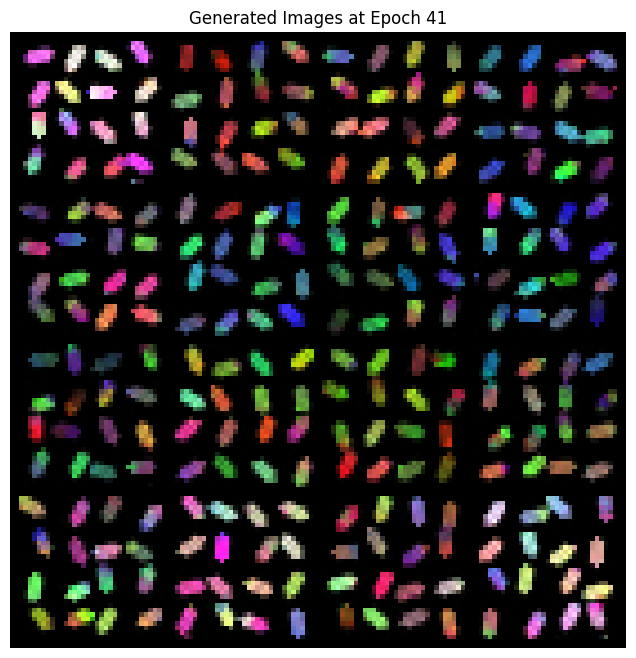

2025-07-07 14:37:07 - INFO - ------------------------------
2025-07-07 14:37:10 - INFO - Epoch: 42/60 | Batch: 0/176 | Loss (NLL): -12902.0625 | BPD: 1.9408
2025-07-07 14:38:55 - INFO - Epoch: 42/60 | Batch: 50/176 | Loss (NLL): -12645.6748 | BPD: 2.0612
2025-07-07 14:40:39 - INFO - Epoch: 42/60 | Batch: 100/176 | Loss (NLL): -12571.1250 | BPD: 2.0963
2025-07-07 14:42:24 - INFO - Epoch: 42/60 | Batch: 150/176 | Loss (NLL): -12609.9316 | BPD: 2.0780
2025-07-07 14:43:17 - INFO - --- Epoch 42 Summary ---
2025-07-07 14:43:17 - INFO - Average Loss: -12599.4553 | Time: 369.90s
2025-07-07 14:43:17 - INFO - Generating sample images...


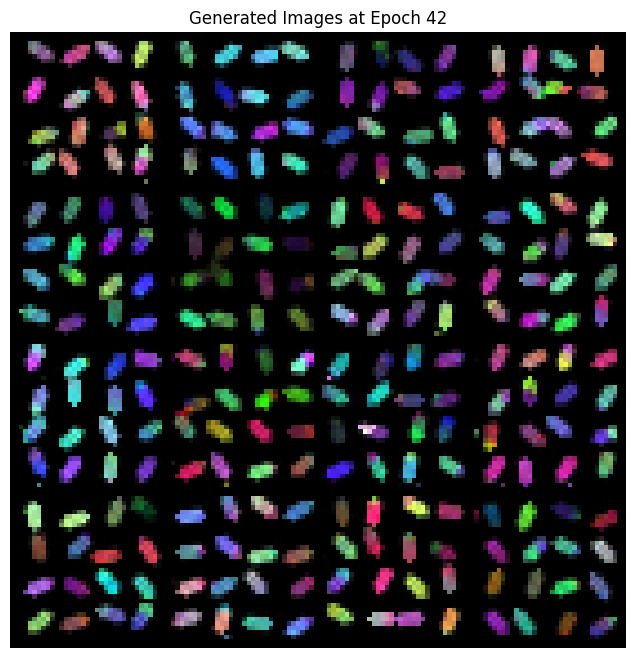

2025-07-07 14:43:17 - INFO - ------------------------------
2025-07-07 14:43:20 - INFO - Epoch: 43/60 | Batch: 0/176 | Loss (NLL): -12433.8945 | BPD: 2.1607
2025-07-07 14:45:05 - INFO - Epoch: 43/60 | Batch: 50/176 | Loss (NLL): -12766.6836 | BPD: 2.0044
2025-07-07 14:46:49 - INFO - Epoch: 43/60 | Batch: 100/176 | Loss (NLL): -12797.6582 | BPD: 1.9899
2025-07-07 14:48:34 - INFO - Epoch: 43/60 | Batch: 150/176 | Loss (NLL): -12694.9805 | BPD: 2.0381
2025-07-07 14:49:26 - INFO - --- Epoch 43 Summary ---
2025-07-07 14:49:26 - INFO - Average Loss: -12622.3418 | Time: 368.91s
2025-07-07 14:49:26 - INFO - Generating sample images...


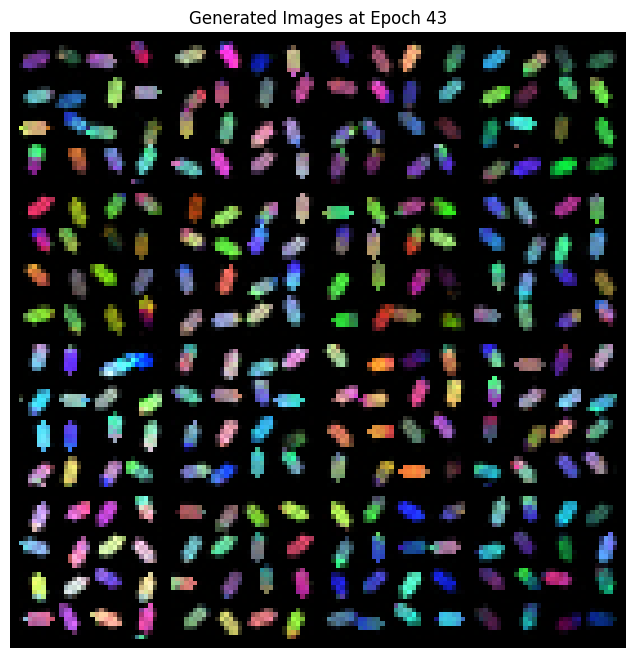

2025-07-07 14:49:27 - INFO - ------------------------------
2025-07-07 14:49:30 - INFO - Epoch: 44/60 | Batch: 0/176 | Loss (NLL): -12416.2021 | BPD: 2.1690
2025-07-07 14:51:15 - INFO - Epoch: 44/60 | Batch: 50/176 | Loss (NLL): -12449.4531 | BPD: 2.1534
2025-07-07 14:52:59 - INFO - Epoch: 44/60 | Batch: 100/176 | Loss (NLL): -12565.7715 | BPD: 2.0988
2025-07-07 14:54:44 - INFO - Epoch: 44/60 | Batch: 150/176 | Loss (NLL): -12725.9521 | BPD: 2.0235
2025-07-07 14:55:36 - INFO - --- Epoch 44 Summary ---
2025-07-07 14:55:36 - INFO - Average Loss: -12629.6171 | Time: 369.11s
2025-07-07 14:55:36 - INFO - Generating sample images...


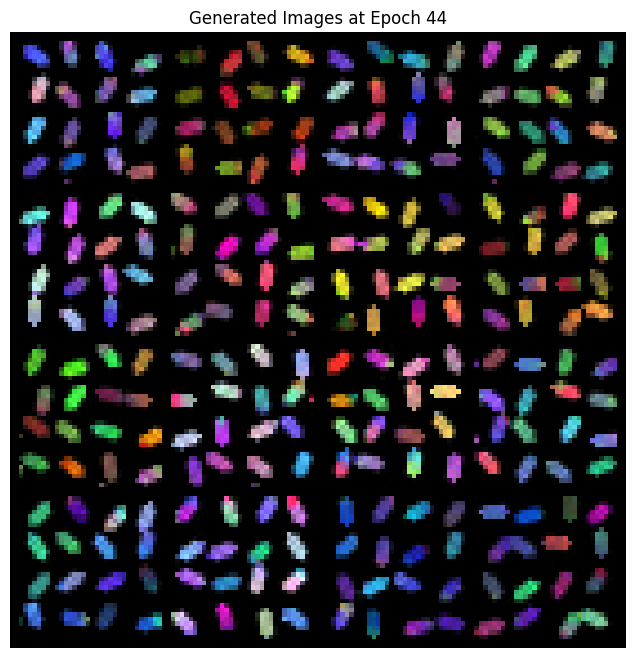

2025-07-07 14:55:36 - INFO - ------------------------------
2025-07-07 14:55:40 - INFO - Epoch: 45/60 | Batch: 0/176 | Loss (NLL): -12608.0547 | BPD: 2.0789
2025-07-07 14:57:25 - INFO - Epoch: 45/60 | Batch: 50/176 | Loss (NLL): -12557.7041 | BPD: 2.1026
2025-07-07 14:59:09 - INFO - Epoch: 45/60 | Batch: 100/176 | Loss (NLL): -12859.1494 | BPD: 1.9610
2025-07-07 15:00:54 - INFO - Epoch: 45/60 | Batch: 150/176 | Loss (NLL): -12848.6172 | BPD: 1.9659
2025-07-07 15:01:46 - INFO - --- Epoch 45 Summary ---
2025-07-07 15:01:46 - INFO - Average Loss: -12655.3288 | Time: 370.05s
2025-07-07 15:01:46 - INFO - Generating sample images...


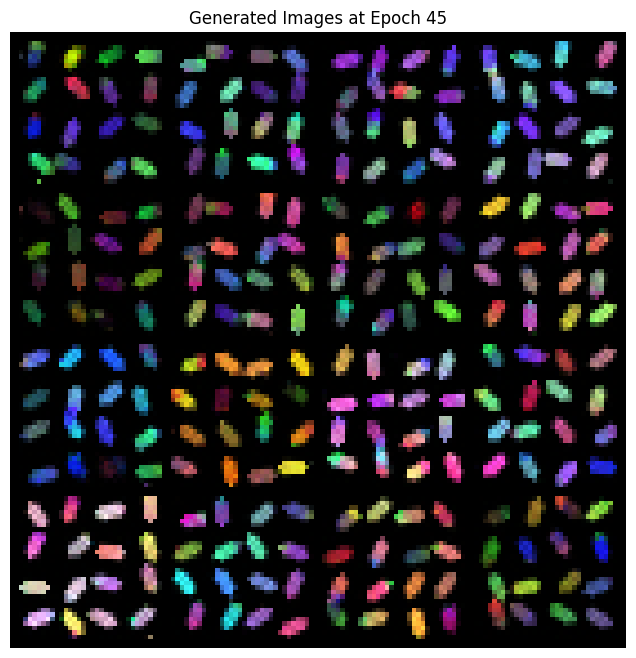

2025-07-07 15:01:47 - INFO - ------------------------------
2025-07-07 15:01:50 - INFO - Epoch: 46/60 | Batch: 0/176 | Loss (NLL): -12453.5752 | BPD: 2.1515
2025-07-07 15:03:35 - INFO - Epoch: 46/60 | Batch: 50/176 | Loss (NLL): -12427.0156 | BPD: 2.1639
2025-07-07 15:05:20 - INFO - Epoch: 46/60 | Batch: 100/176 | Loss (NLL): -12818.6816 | BPD: 1.9800
2025-07-07 15:07:04 - INFO - Epoch: 46/60 | Batch: 150/176 | Loss (NLL): -12805.0068 | BPD: 1.9864
2025-07-07 15:07:56 - INFO - --- Epoch 46 Summary ---
2025-07-07 15:07:56 - INFO - Average Loss: -12718.3273 | Time: 369.46s
2025-07-07 15:07:56 - INFO - Generating sample images...


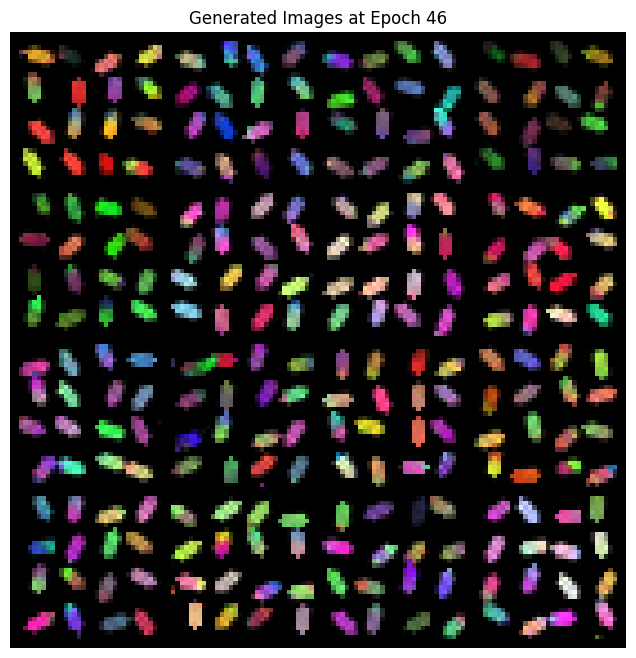

2025-07-07 15:07:57 - INFO - ------------------------------
2025-07-07 15:08:00 - INFO - Epoch: 47/60 | Batch: 0/176 | Loss (NLL): -12461.0615 | BPD: 2.1479
2025-07-07 15:09:44 - INFO - Epoch: 47/60 | Batch: 50/176 | Loss (NLL): -12669.2314 | BPD: 2.0502
2025-07-07 15:11:29 - INFO - Epoch: 47/60 | Batch: 100/176 | Loss (NLL): -12741.3545 | BPD: 2.0163
2025-07-07 15:13:14 - INFO - Epoch: 47/60 | Batch: 150/176 | Loss (NLL): -12554.3438 | BPD: 2.1041
2025-07-07 15:14:06 - INFO - --- Epoch 47 Summary ---
2025-07-07 15:14:06 - INFO - Average Loss: -12749.0597 | Time: 369.48s
2025-07-07 15:14:06 - INFO - Generating sample images...


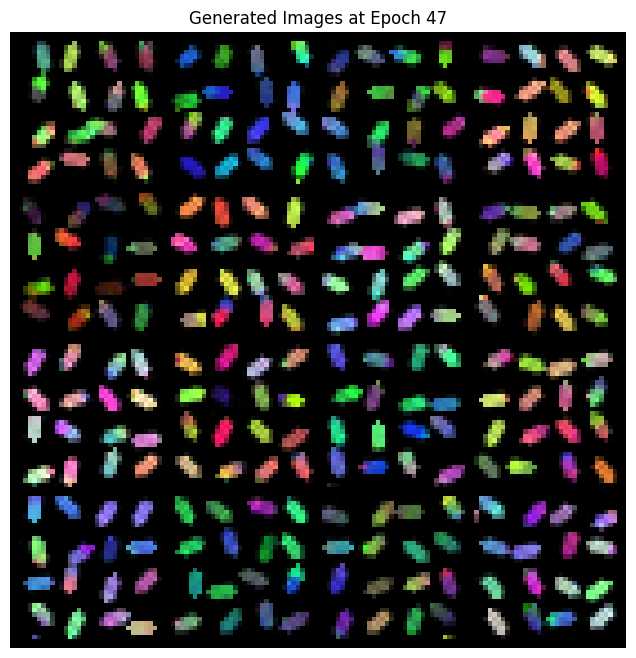

2025-07-07 15:14:07 - INFO - ------------------------------
2025-07-07 15:14:10 - INFO - Epoch: 48/60 | Batch: 0/176 | Loss (NLL): -12498.3047 | BPD: 2.1305
2025-07-07 15:15:55 - INFO - Epoch: 48/60 | Batch: 50/176 | Loss (NLL): -12867.6387 | BPD: 1.9570
2025-07-07 15:17:39 - INFO - Epoch: 48/60 | Batch: 100/176 | Loss (NLL): -12650.0264 | BPD: 2.0592
2025-07-07 15:19:24 - INFO - Epoch: 48/60 | Batch: 150/176 | Loss (NLL): -12913.4785 | BPD: 1.9355
2025-07-07 15:20:16 - INFO - --- Epoch 48 Summary ---
2025-07-07 15:20:16 - INFO - Average Loss: -12745.8676 | Time: 368.95s
2025-07-07 15:20:16 - INFO - Generating sample images...


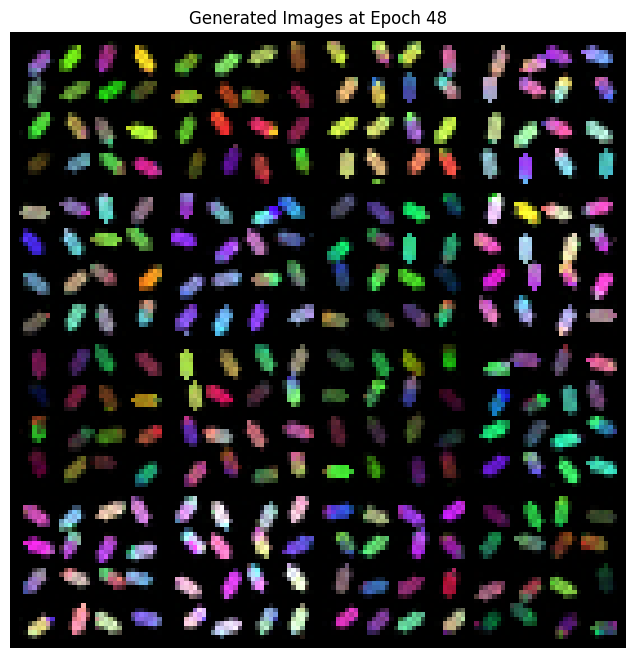

2025-07-07 15:20:16 - INFO - ------------------------------
2025-07-07 15:20:19 - INFO - Epoch: 49/60 | Batch: 0/176 | Loss (NLL): -12692.0195 | BPD: 2.0395
2025-07-07 15:22:03 - INFO - Epoch: 49/60 | Batch: 50/176 | Loss (NLL): -12973.1963 | BPD: 1.9074
2025-07-07 15:23:48 - INFO - Epoch: 49/60 | Batch: 100/176 | Loss (NLL): -12933.6250 | BPD: 1.9260
2025-07-07 15:25:32 - INFO - Epoch: 49/60 | Batch: 150/176 | Loss (NLL): -12860.6211 | BPD: 1.9603
2025-07-07 15:26:24 - INFO - --- Epoch 49 Summary ---
2025-07-07 15:26:24 - INFO - Average Loss: -12763.0958 | Time: 367.63s
2025-07-07 15:26:24 - INFO - Generating sample images...


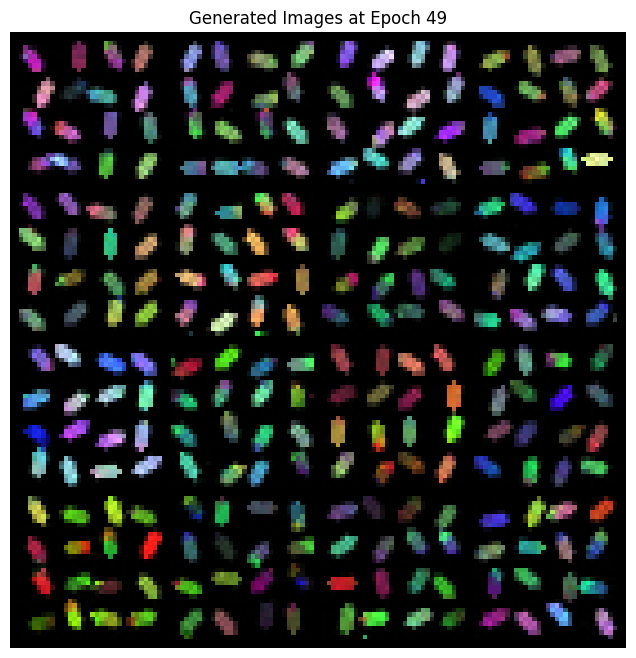

2025-07-07 15:26:24 - INFO - ------------------------------
2025-07-07 15:26:27 - INFO - Epoch: 50/60 | Batch: 0/176 | Loss (NLL): -12764.9746 | BPD: 2.0052
2025-07-07 15:28:12 - INFO - Epoch: 50/60 | Batch: 50/176 | Loss (NLL): -12821.2402 | BPD: 1.9788
2025-07-07 15:29:57 - INFO - Epoch: 50/60 | Batch: 100/176 | Loss (NLL): -12780.7266 | BPD: 1.9978
2025-07-07 15:31:42 - INFO - Epoch: 50/60 | Batch: 150/176 | Loss (NLL): -12684.5205 | BPD: 2.0430
2025-07-07 15:32:34 - INFO - --- Epoch 50 Summary ---
2025-07-07 15:32:34 - INFO - Average Loss: -12816.0951 | Time: 369.34s
2025-07-07 15:32:34 - INFO - Generating sample images...


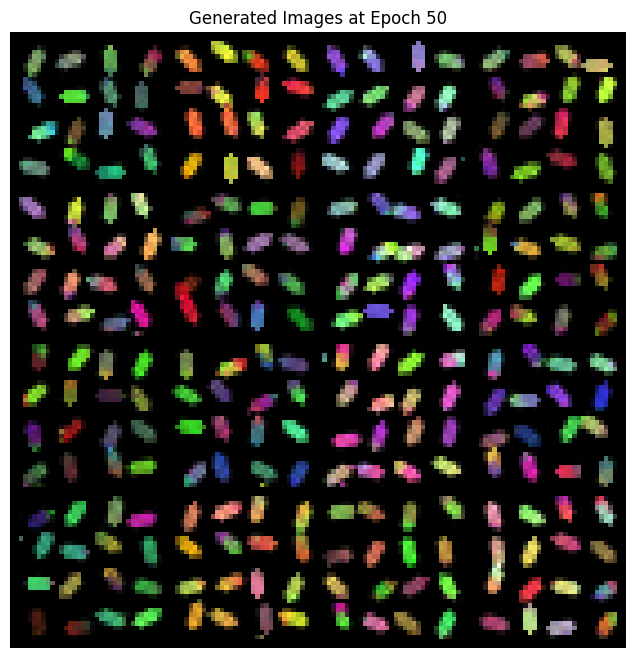

2025-07-07 15:32:34 - INFO - ------------------------------
2025-07-07 15:32:37 - INFO - Epoch: 51/60 | Batch: 0/176 | Loss (NLL): -12778.9277 | BPD: 1.9987
2025-07-07 15:34:22 - INFO - Epoch: 51/60 | Batch: 50/176 | Loss (NLL): -12531.0303 | BPD: 2.1151
2025-07-07 15:36:07 - INFO - Epoch: 51/60 | Batch: 100/176 | Loss (NLL): -12786.2754 | BPD: 1.9952
2025-07-07 15:37:51 - INFO - Epoch: 51/60 | Batch: 150/176 | Loss (NLL): -12843.7383 | BPD: 1.9682
2025-07-07 15:38:44 - INFO - --- Epoch 51 Summary ---
2025-07-07 15:38:44 - INFO - Average Loss: -12822.3110 | Time: 369.71s
2025-07-07 15:38:44 - INFO - Generating sample images...


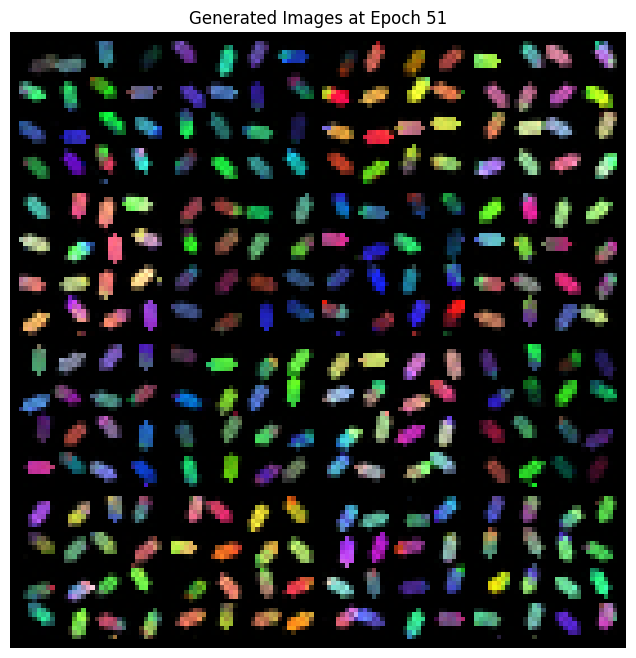

2025-07-07 15:38:44 - INFO - ------------------------------
2025-07-07 15:38:47 - INFO - Epoch: 52/60 | Batch: 0/176 | Loss (NLL): -12612.1230 | BPD: 2.0770
2025-07-07 15:40:32 - INFO - Epoch: 52/60 | Batch: 50/176 | Loss (NLL): -12790.9912 | BPD: 1.9930
2025-07-07 15:42:17 - INFO - Epoch: 52/60 | Batch: 100/176 | Loss (NLL): -12844.9766 | BPD: 1.9676
2025-07-07 15:44:02 - INFO - Epoch: 52/60 | Batch: 150/176 | Loss (NLL): -12759.8086 | BPD: 2.0076
2025-07-07 15:44:54 - INFO - --- Epoch 52 Summary ---
2025-07-07 15:44:54 - INFO - Average Loss: -12874.0611 | Time: 369.55s
2025-07-07 15:44:54 - INFO - Generating sample images...


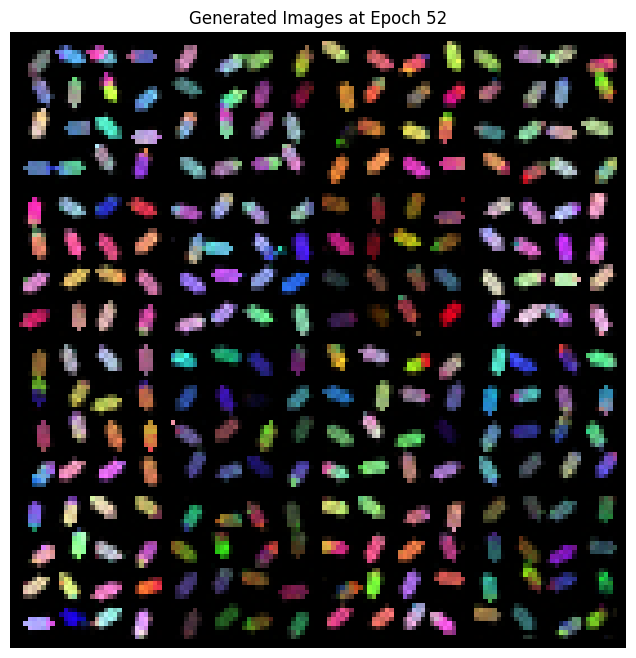

2025-07-07 15:44:54 - INFO - ------------------------------
2025-07-07 15:44:58 - INFO - Epoch: 53/60 | Batch: 0/176 | Loss (NLL): -12864.8477 | BPD: 1.9583
2025-07-07 15:46:43 - INFO - Epoch: 53/60 | Batch: 50/176 | Loss (NLL): -12803.5625 | BPD: 1.9871
2025-07-07 15:48:27 - INFO - Epoch: 53/60 | Batch: 100/176 | Loss (NLL): -12505.1426 | BPD: 2.1272
2025-07-07 15:50:12 - INFO - Epoch: 53/60 | Batch: 150/176 | Loss (NLL): -12464.9531 | BPD: 2.1461
2025-07-07 15:51:05 - INFO - --- Epoch 53 Summary ---
2025-07-07 15:51:05 - INFO - Average Loss: -12814.4779 | Time: 370.01s
2025-07-07 15:51:05 - INFO - Generating sample images...


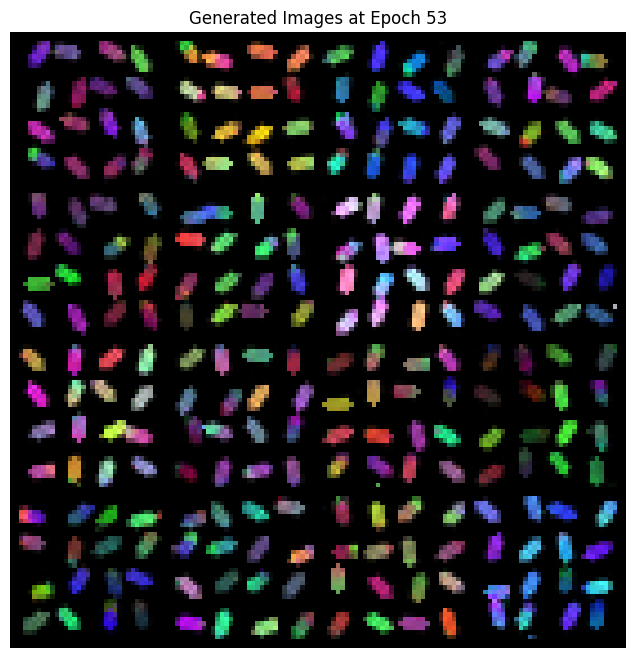

2025-07-07 15:51:05 - INFO - ------------------------------
2025-07-07 15:51:08 - INFO - Epoch: 54/60 | Batch: 0/176 | Loss (NLL): -12973.4541 | BPD: 1.9073
2025-07-07 15:52:53 - INFO - Epoch: 54/60 | Batch: 50/176 | Loss (NLL): -12883.5303 | BPD: 1.9495
2025-07-07 15:54:38 - INFO - Epoch: 54/60 | Batch: 100/176 | Loss (NLL): -12930.1133 | BPD: 1.9277
2025-07-07 15:56:22 - INFO - Epoch: 54/60 | Batch: 150/176 | Loss (NLL): -12858.2266 | BPD: 1.9614
2025-07-07 15:57:15 - INFO - --- Epoch 54 Summary ---
2025-07-07 15:57:15 - INFO - Average Loss: -12908.7707 | Time: 369.95s
2025-07-07 15:57:15 - INFO - Generating sample images...


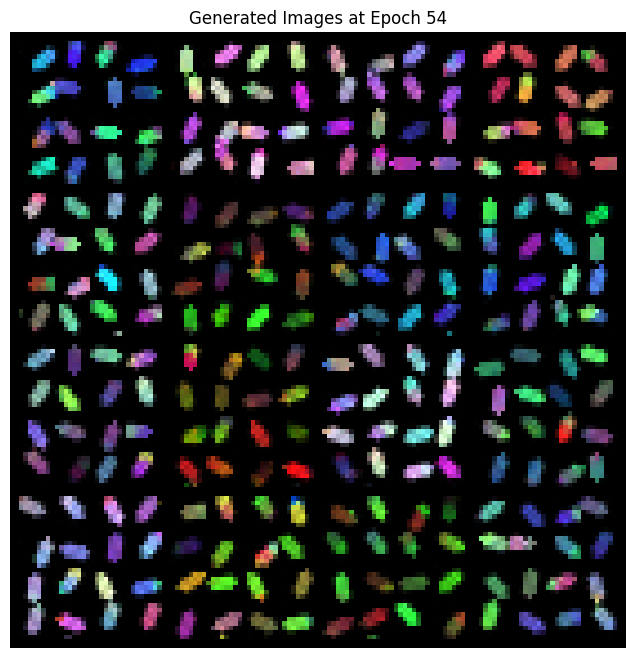

2025-07-07 15:57:15 - INFO - ------------------------------
2025-07-07 15:57:18 - INFO - Epoch: 55/60 | Batch: 0/176 | Loss (NLL): -12897.0684 | BPD: 1.9432
2025-07-07 15:59:03 - INFO - Epoch: 55/60 | Batch: 50/176 | Loss (NLL): -12988.8232 | BPD: 1.9001
2025-07-07 16:00:47 - INFO - Epoch: 55/60 | Batch: 100/176 | Loss (NLL): -12845.2764 | BPD: 1.9675
2025-07-07 16:02:32 - INFO - Epoch: 55/60 | Batch: 150/176 | Loss (NLL): -12871.8330 | BPD: 1.9550
2025-07-07 16:03:24 - INFO - --- Epoch 55 Summary ---
2025-07-07 16:03:24 - INFO - Average Loss: -12923.4010 | Time: 368.88s
2025-07-07 16:03:24 - INFO - Generating sample images...


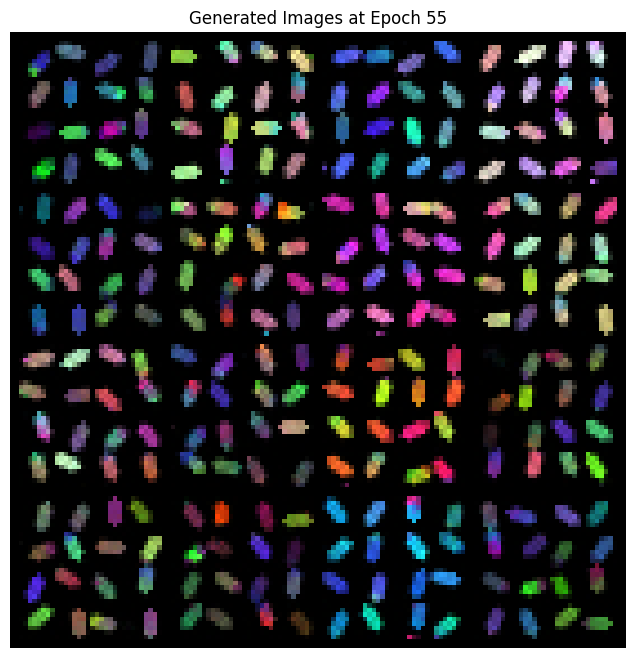

2025-07-07 16:03:25 - INFO - ------------------------------
2025-07-07 16:03:28 - INFO - Epoch: 56/60 | Batch: 0/176 | Loss (NLL): -13150.1895 | BPD: 1.8243
2025-07-07 16:05:12 - INFO - Epoch: 56/60 | Batch: 50/176 | Loss (NLL): -12859.5352 | BPD: 1.9608
2025-07-07 16:06:57 - INFO - Epoch: 56/60 | Batch: 100/176 | Loss (NLL): -12979.5879 | BPD: 1.9044
2025-07-07 16:08:41 - INFO - Epoch: 56/60 | Batch: 150/176 | Loss (NLL): -13071.0312 | BPD: 1.8615
2025-07-07 16:09:33 - INFO - --- Epoch 56 Summary ---
2025-07-07 16:09:33 - INFO - Average Loss: -12927.1057 | Time: 368.01s
2025-07-07 16:09:33 - INFO - Generating sample images...


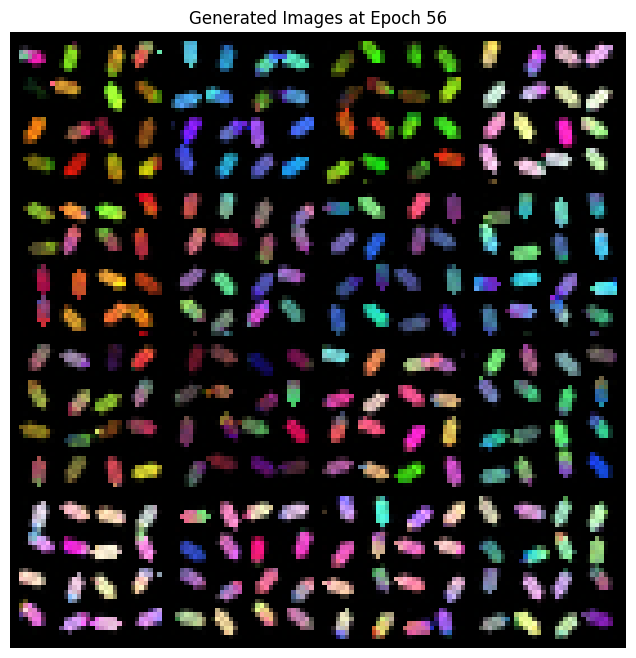

2025-07-07 16:09:33 - INFO - ------------------------------
2025-07-07 16:09:36 - INFO - Epoch: 57/60 | Batch: 0/176 | Loss (NLL): -12894.5977 | BPD: 1.9443
2025-07-07 16:11:21 - INFO - Epoch: 57/60 | Batch: 50/176 | Loss (NLL): -12946.0488 | BPD: 1.9202
2025-07-07 16:13:05 - INFO - Epoch: 57/60 | Batch: 100/176 | Loss (NLL): -13068.3496 | BPD: 1.8627
2025-07-07 16:14:49 - INFO - Epoch: 57/60 | Batch: 150/176 | Loss (NLL): -13060.3691 | BPD: 1.8665
2025-07-07 16:15:41 - INFO - --- Epoch 57 Summary ---
2025-07-07 16:15:41 - INFO - Average Loss: -12948.5603 | Time: 368.21s
2025-07-07 16:15:41 - INFO - Generating sample images...


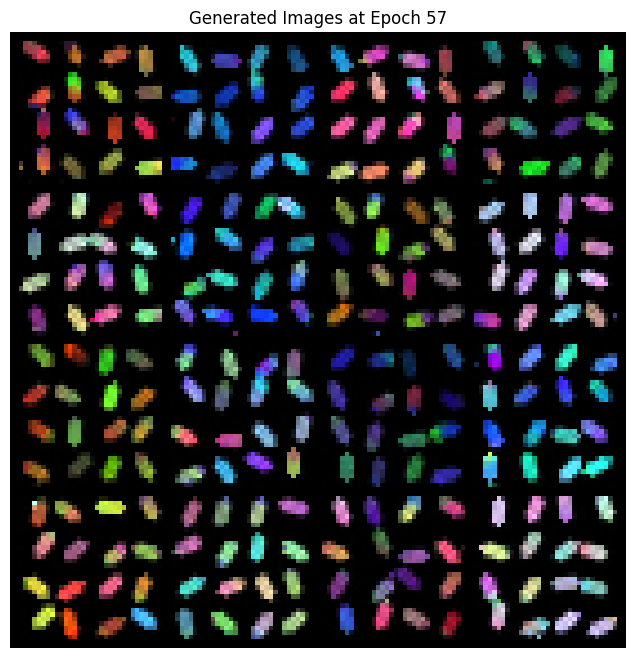

2025-07-07 16:15:42 - INFO - ------------------------------
2025-07-07 16:15:45 - INFO - Epoch: 58/60 | Batch: 0/176 | Loss (NLL): -12782.3340 | BPD: 1.9971
2025-07-07 16:17:30 - INFO - Epoch: 58/60 | Batch: 50/176 | Loss (NLL): -13012.2607 | BPD: 1.8891
2025-07-07 16:19:15 - INFO - Epoch: 58/60 | Batch: 100/176 | Loss (NLL): -12785.7773 | BPD: 1.9955
2025-07-07 16:20:59 - INFO - Epoch: 58/60 | Batch: 150/176 | Loss (NLL): -12703.7451 | BPD: 2.0340
2025-07-07 16:21:51 - INFO - --- Epoch 58 Summary ---
2025-07-07 16:21:51 - INFO - Average Loss: -12931.8243 | Time: 368.97s
2025-07-07 16:21:51 - INFO - Generating sample images...


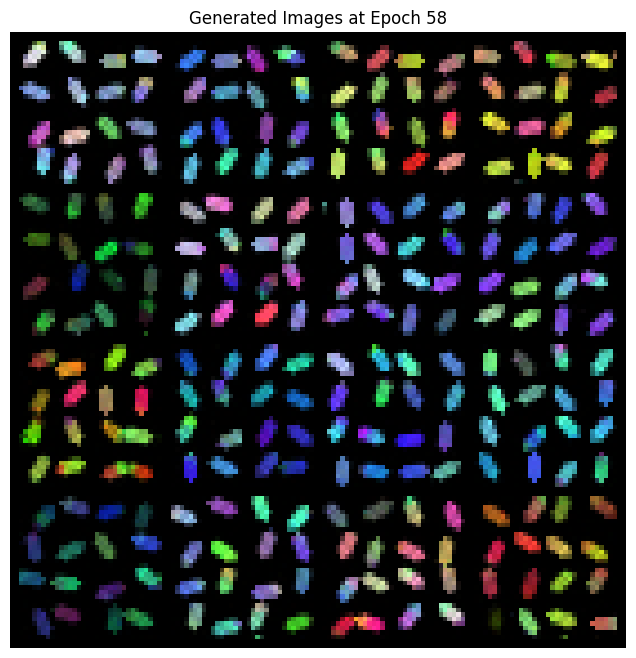

2025-07-07 16:21:51 - INFO - ------------------------------
2025-07-07 16:21:54 - INFO - Epoch: 59/60 | Batch: 0/176 | Loss (NLL): -12885.9199 | BPD: 1.9484
2025-07-07 16:23:39 - INFO - Epoch: 59/60 | Batch: 50/176 | Loss (NLL): -12971.3223 | BPD: 1.9083
2025-07-07 16:25:24 - INFO - Epoch: 59/60 | Batch: 100/176 | Loss (NLL): -12921.5654 | BPD: 1.9317
2025-07-07 16:27:08 - INFO - Epoch: 59/60 | Batch: 150/176 | Loss (NLL): -13071.4805 | BPD: 1.8613
2025-07-07 16:28:00 - INFO - --- Epoch 59 Summary ---
2025-07-07 16:28:00 - INFO - Average Loss: -12955.5846 | Time: 368.75s
2025-07-07 16:28:00 - INFO - Generating sample images...


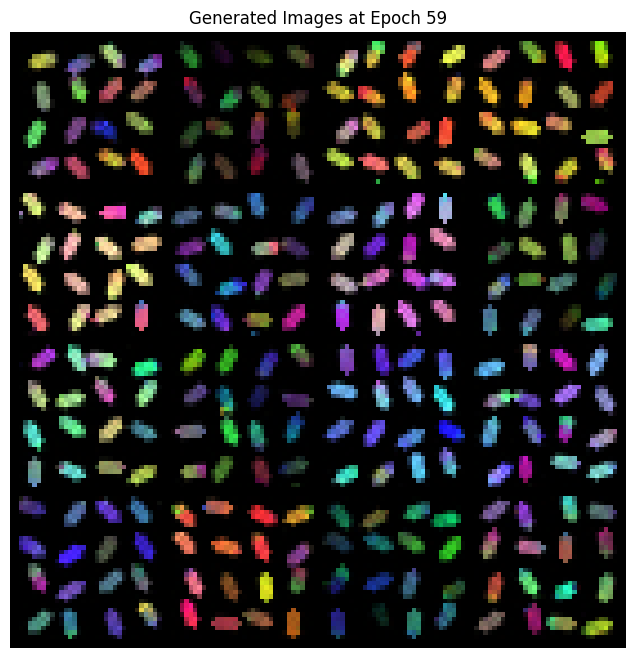

2025-07-07 16:28:01 - INFO - ------------------------------
2025-07-07 16:28:04 - INFO - Epoch: 60/60 | Batch: 0/176 | Loss (NLL): -12884.9434 | BPD: 1.9489
2025-07-07 16:29:48 - INFO - Epoch: 60/60 | Batch: 50/176 | Loss (NLL): -13100.5098 | BPD: 1.8476
2025-07-07 16:31:33 - INFO - Epoch: 60/60 | Batch: 100/176 | Loss (NLL): -13027.9111 | BPD: 1.8817
2025-07-07 16:33:18 - INFO - Epoch: 60/60 | Batch: 150/176 | Loss (NLL): -13094.3330 | BPD: 1.8505
2025-07-07 16:34:10 - INFO - --- Epoch 60 Summary ---
2025-07-07 16:34:10 - INFO - Average Loss: -13019.4124 | Time: 369.48s
2025-07-07 16:34:10 - INFO - Generating sample images...


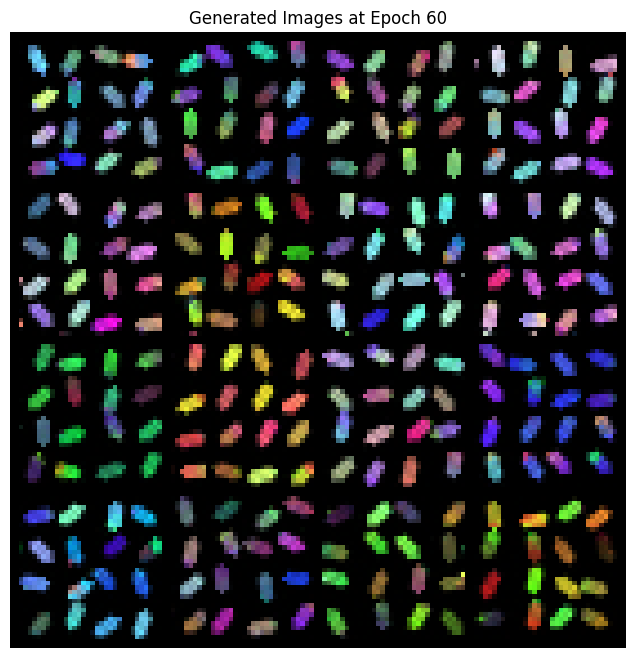

2025-07-07 16:34:11 - INFO - ------------------------------


In [ ]:
IMAGE_SIZE = 32
NUM_CHANNELS = 3
BATCH_SIZE = batch_size
LEARNING_RATE = 1e-3
NUM_EPOCHS = 60
prior_str = "laplace"
prior = PriorDistribution(dist_type=prior_str)


logger = setup_logger()
optimizer = torch.optim.AdamW(flow.parameters(), lr=LEARNING_RATE, weight_decay=5e-5)


try:
    train_rg_flow(
        model=flow,
        prior=prior,
        train_loader=train_loader,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        image_dims=(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE),
        logger=logger,
        num_images_to_generate=16
    )
except Exception as e:
    logger.error("An error occurred during training!", exc_info=True)

In [ ]:
from google.colab import files
# Download the generated images directory
!zip -r generated_images.zip generated_images
files.download('generated_images.zip')
# Download the model weights file

  adding: generated_images/ (stored 0%)
  adding: generated_images/epoch_037.png (deflated 9%)
  adding: generated_images/epoch_022.png (deflated 9%)
  adding: generated_images/epoch_051.png (deflated 9%)
  adding: generated_images/epoch_052.png (deflated 9%)
  adding: generated_images/epoch_036.png (deflated 9%)
  adding: generated_images/epoch_043.png (deflated 9%)
  adding: generated_images/epoch_002.png (deflated 9%)
  adding: generated_images/epoch_047.png (deflated 9%)
  adding: generated_images/epoch_028.png (deflated 9%)
  adding: generated_images/epoch_048.png (deflated 9%)
  adding: generated_images/epoch_050.png (deflated 9%)
  adding: generated_images/epoch_029.png (deflated 9%)
  adding: generated_images/epoch_005.png (deflated 8%)
  adding: generated_images/epoch_055.png (deflated 9%)
  adding: generated_images/epoch_040.png (deflated 9%)
  adding: generated_images/epoch_042.png (deflated 9%)
  adding: generated_images/epoch_056.png (deflated 9%)
  adding: generated_image

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

from datetime import datetime


timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
MODEL_WEIGHTS_PATH = f"rg_flow_weights_{timestamp}_{NUM_EPOCHS}_MSD1_{prior_str}.pth"

print(f"Saving model weights to {MODEL_WEIGHTS_PATH}...")

torch.save(flow.state_dict(), MODEL_WEIGHTS_PATH)

print("Model weights saved successfully.")
files.download(MODEL_WEIGHTS_PATH)

Saving model weights to rg_flow_weights_2025-07-07_16-34-11_60_MSD1_laplace.pth...
Model weights saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

optimizer_path = f"rg_flow_optimizer_{timestamp}_{NUM_EPOCHS}_MSD1_{prior_str}.pth"

print(f"Saving optimizer state to {optimizer_path}...")

torch.save(optimizer.state_dict(), optimizer_path)

print("Optimizer state saved successfully.")

files.download(optimizer_path)

Saving optimizer state to rg_flow_optimizer_2025-07-07_16-34-11_60_MSD1_laplace.pth...
Optimizer state saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>